In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f37d213eee0>,)

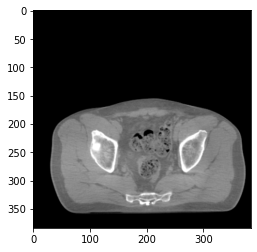

In [29]:
plt.imshow(x.squeeze(), 'gray'),

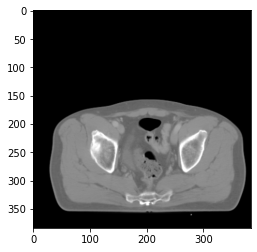

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=20, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=20, T_mult=2)

In [39]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:42,  1.98it/s]
84it [01:27,  1.04s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.53it/s]
84it [00:40,  2.08it/s]
84it [01:28,  1.05s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.08it/s]
84it [01:28,  1.05s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.54it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.53it/s]
84it [00:40,  2.07it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.55it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.07it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.07it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.55it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.80it/s]
12it [00:04,  2.54it/s]
84it [00:40,  2.08it/s]
84it [01:29,  1.

In [40]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [41]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [42]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8583567142486572
psnr score = 25.220012664794922
snr score = 15.282949447631836
mae error = 0.02127198688685894
air dice score = 0.9978359236671278
bone dice score = 0.934726639407319
contour dice score = 0.5623880624771118


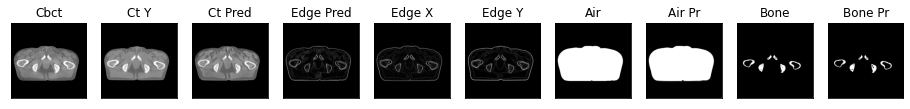

1it [00:00,  2.04it/s]

ssim score = 0.8593300580978394
psnr score = 25.11275291442871
snr score = 15.223226547241211
mae error = 0.02168388105928898
air dice score = 0.997709826123711
bone dice score = 0.9377455424608984
contour dice score = 0.5780969262123108


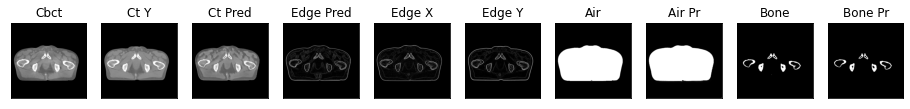

2it [00:00,  2.19it/s]

ssim score = 0.8588619232177734
psnr score = 24.701160430908203
snr score = 14.974531173706055
mae error = 0.023887071758508682
air dice score = 0.9976988435213617
bone dice score = 0.9187524066240694
contour dice score = 0.5452366471290588


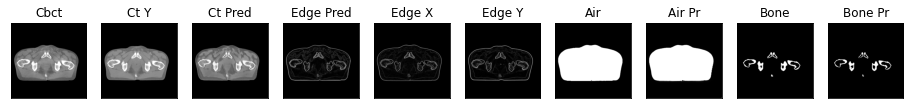

3it [00:01,  1.97it/s]

ssim score = 0.8544098138809204
psnr score = 24.51624298095703
snr score = 14.87886905670166
mae error = 0.02518502064049244
air dice score = 0.9977529861631276
bone dice score = 0.9058452922657116
contour dice score = 0.625825822353363


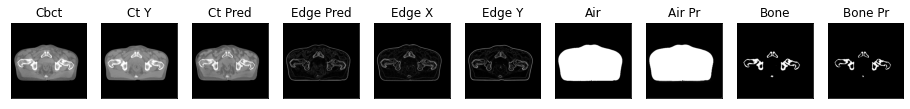

4it [00:01,  2.15it/s]

ssim score = 0.8578362464904785
psnr score = 24.54860496520996
snr score = 14.951526641845703
mae error = 0.025410672649741173
air dice score = 0.9979337821672569
bone dice score = 0.8809549413928277
contour dice score = 0.6181599497795105


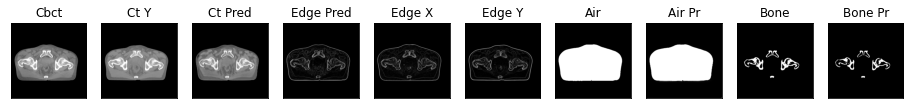

5it [00:02,  2.28it/s]

ssim score = 0.8533393740653992
psnr score = 24.100038528442383
snr score = 14.639497756958008
mae error = 0.027660051360726357
air dice score = 0.9972808828199455
bone dice score = 0.8411126826983394
contour dice score = 0.6586248278617859


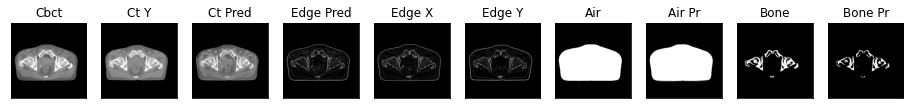

6it [00:02,  2.40it/s]

ssim score = 0.8513916730880737
psnr score = 24.006263732910156
snr score = 14.52166748046875
mae error = 0.027259431779384613
air dice score = 0.9973723911240797
bone dice score = 0.8493126067045619
contour dice score = 0.6303690075874329


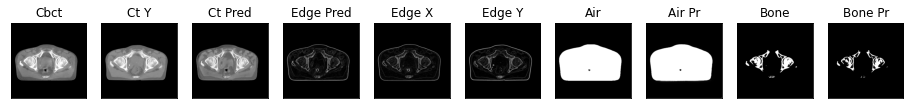

7it [00:02,  2.47it/s]

ssim score = 0.8534969687461853
psnr score = 24.66967010498047
snr score = 14.999536514282227
mae error = 0.024617400020360947
air dice score = 0.9972363753303816
bone dice score = 0.8972033979202328
contour dice score = 0.5828779339790344


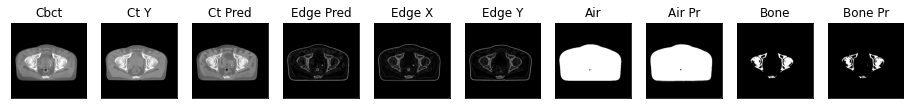

8it [00:03,  2.49it/s]

ssim score = 0.8565464615821838
psnr score = 25.08307456970215
snr score = 15.318384170532227
mae error = 0.023403752595186234
air dice score = 0.9979674591216613
bone dice score = 0.9239339613093899
contour dice score = 0.5809987783432007


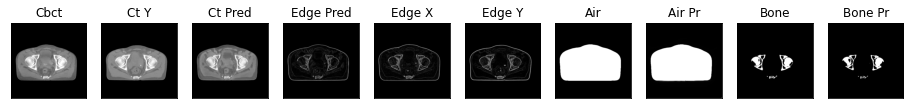

9it [00:03,  2.53it/s]

ssim score = 0.8602068424224854
psnr score = 25.02678108215332
snr score = 15.246809005737305
mae error = 0.02363111637532711
air dice score = 0.997229521888817
bone dice score = 0.9197235513033523
contour dice score = 0.5033597946166992


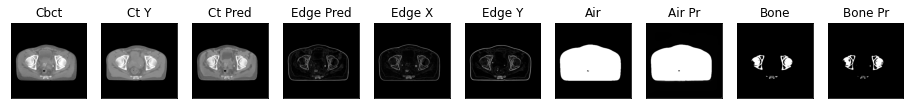

10it [00:04,  2.56it/s]

ssim score = 0.8659640550613403
psnr score = 25.183523178100586
snr score = 15.435819625854492
mae error = 0.0236064400523901
air dice score = 0.997213400266369
bone dice score = 0.9316019254457449
contour dice score = 0.47310513257980347


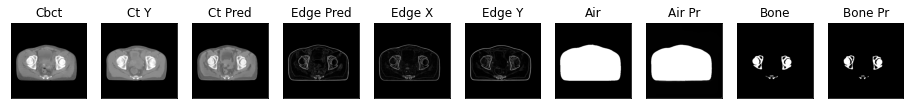

11it [00:04,  2.56it/s]

ssim score = 0.8639974594116211
psnr score = 24.36278533935547
snr score = 14.6387939453125
mae error = 0.0248864833265543
air dice score = 0.9972350230414775
bone dice score = 0.92666967509108
contour dice score = 0.4837721884250641


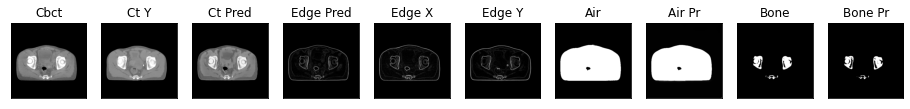

12it [00:04,  2.57it/s]

ssim score = 0.8685362935066223
psnr score = 23.941316604614258
snr score = 14.185401916503906
mae error = 0.025175567716360092
air dice score = 0.9968902151719837
bone dice score = 0.9444906692030846
contour dice score = 0.5088902711868286


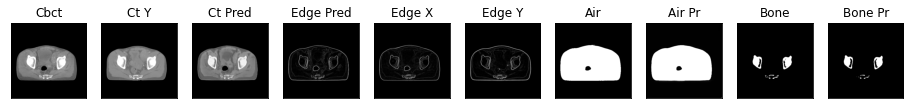

13it [00:05,  2.24it/s]

ssim score = 0.8669320344924927
psnr score = 23.909751892089844
snr score = 14.011878967285156
mae error = 0.024262309074401855
air dice score = 0.9965468081736136
bone dice score = 0.9211629125206763
contour dice score = 0.5311920642852783


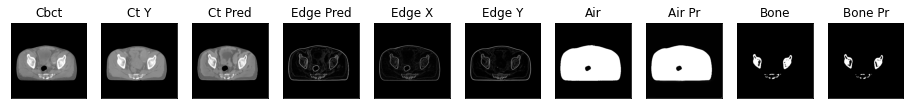

14it [00:05,  2.36it/s]

ssim score = 0.8654923439025879
psnr score = 23.999935150146484
snr score = 14.016400337219238
mae error = 0.023861709982156754
air dice score = 0.9968900257926222
bone dice score = 0.916735822961041
contour dice score = 0.5811227560043335


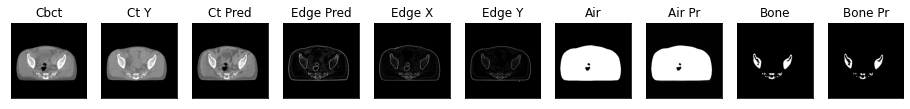

15it [00:06,  2.43it/s]

ssim score = 0.8561986088752747
psnr score = 23.708221435546875
snr score = 13.748169898986816
mae error = 0.025177001953125
air dice score = 0.9973637304814689
bone dice score = 0.9153538050745613
contour dice score = 0.640400230884552


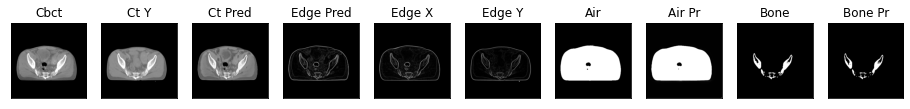

16it [00:06,  2.48it/s]

ssim score = 0.8564227819442749
psnr score = 23.080904006958008
snr score = 13.11831283569336
mae error = 0.026463622227311134
air dice score = 0.997279381599122
bone dice score = 0.9072164948465418
contour dice score = 0.6461344957351685


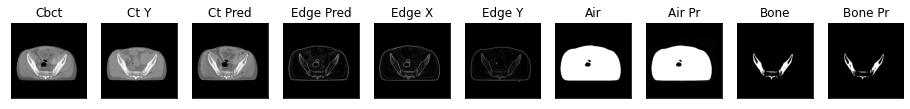

17it [00:06,  2.56it/s]

ssim score = 0.8518431186676025
psnr score = 22.672311782836914
snr score = 12.607959747314453
mae error = 0.02689092606306076
air dice score = 0.996195646249609
bone dice score = 0.8754119973648594
contour dice score = 0.6460012197494507


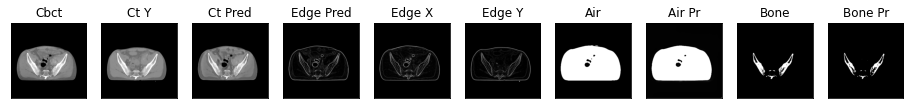

18it [00:07,  2.62it/s]

ssim score = 0.8487975597381592
psnr score = 22.381881713867188
snr score = 12.266847610473633
mae error = 0.027554748579859734
air dice score = 0.9953332088855754
bone dice score = 0.8784974093279987
contour dice score = 0.6475462317466736


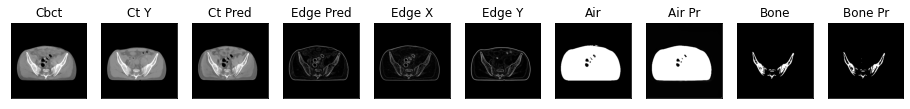

19it [00:07,  2.66it/s]

ssim score = 0.8512555360794067
psnr score = 22.417848587036133
snr score = 12.290504455566406
mae error = 0.027943449094891548
air dice score = 0.9959662713981059
bone dice score = 0.8833488868166465
contour dice score = 0.5927802324295044


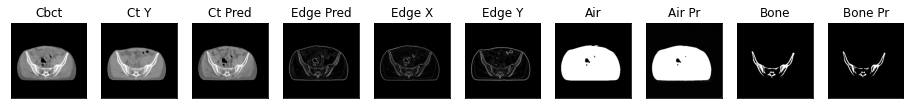

20it [00:08,  2.68it/s]

ssim score = 0.8476406931877136
psnr score = 22.265735626220703
snr score = 12.073545455932617
mae error = 0.02809542790055275
air dice score = 0.9962074735080912
bone dice score = 0.8823614527581773
contour dice score = 0.4817424714565277


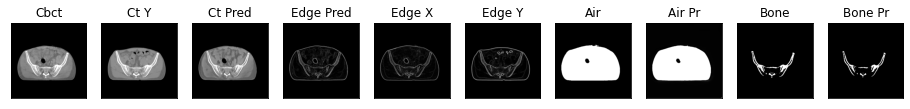

21it [00:08,  2.70it/s]

ssim score = 0.8481213450431824
psnr score = 22.38214111328125
snr score = 12.130517959594727
mae error = 0.02725648693740368
air dice score = 0.9945772378717684
bone dice score = 0.8901520534334212
contour dice score = 0.5151710510253906


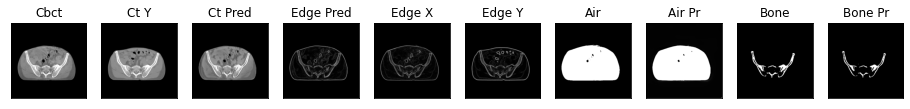

22it [00:08,  2.72it/s]

ssim score = 0.8528050780296326
psnr score = 22.532917022705078
snr score = 12.247867584228516
mae error = 0.026889726519584656
air dice score = 0.9952215021054955
bone dice score = 0.8900160170863586
contour dice score = 0.5896103978157043


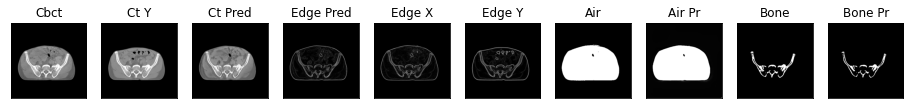

23it [00:09,  2.34it/s]

ssim score = 0.8532114028930664
psnr score = 22.548053741455078
snr score = 12.214441299438477
mae error = 0.026720218360424042
air dice score = 0.9952118032486481
bone dice score = 0.8823225806466797
contour dice score = 0.5489417910575867


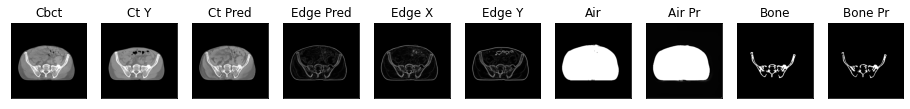

24it [00:09,  2.45it/s]

ssim score = 0.8504567742347717
psnr score = 22.50728416442871
snr score = 12.076669692993164
mae error = 0.026418685913085938
air dice score = 0.9940701811501592
bone dice score = 0.8762950942469567
contour dice score = 0.46948355436325073


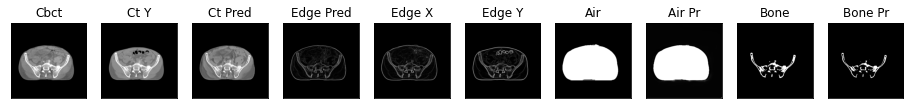

25it [00:10,  2.54it/s]

ssim score = 0.8539490103721619
psnr score = 22.672332763671875
snr score = 12.158985137939453
mae error = 0.02553006447851658
air dice score = 0.9948340359836175
bone dice score = 0.8708716165896341
contour dice score = 0.58152174949646


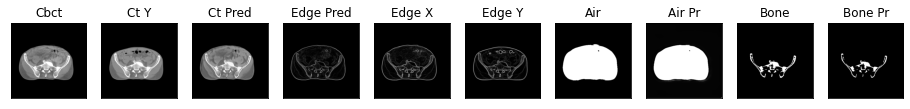

26it [00:10,  2.60it/s]

ssim score = 0.8523919582366943
psnr score = 22.857349395751953
snr score = 12.252815246582031
mae error = 0.024839792400598526
air dice score = 0.9938711240310152
bone dice score = 0.8809234507912402
contour dice score = 0.6550522446632385


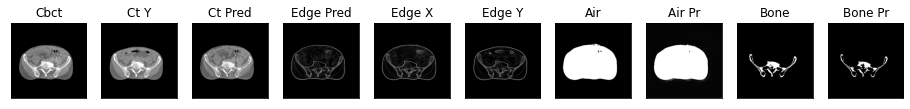

27it [00:10,  2.64it/s]

ssim score = 0.8529329895973206
psnr score = 22.75741195678711
snr score = 12.111769676208496
mae error = 0.024939104914665222
air dice score = 0.993734181880736
bone dice score = 0.8788615064227829
contour dice score = 0.6577464938163757


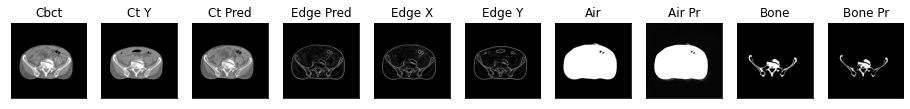

28it [00:11,  2.68it/s]

ssim score = 0.8184018731117249
psnr score = 23.437803268432617
snr score = 14.809959411621094
mae error = 0.027511097490787506
air dice score = 0.9965942163601482
bone dice score = 0.9683818970871549
contour dice score = 0.3546881675720215


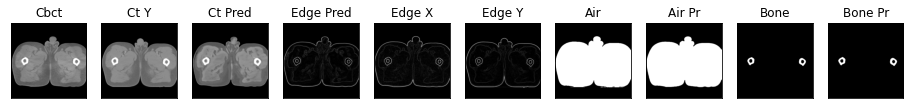

29it [00:11,  2.70it/s]

ssim score = 0.827373206615448
psnr score = 24.052413940429688
snr score = 15.463830947875977
mae error = 0.02627485617995262
air dice score = 0.9959340868253399
bone dice score = 0.9691860465125237
contour dice score = 0.3371259868144989


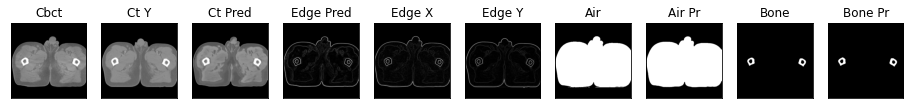

30it [00:11,  2.71it/s]

ssim score = 0.8300401568412781
psnr score = 24.50363540649414
snr score = 16.00250244140625
mae error = 0.026184285059571266
air dice score = 0.9962613863315333
bone dice score = 0.9697529438935638
contour dice score = 0.31144630908966064


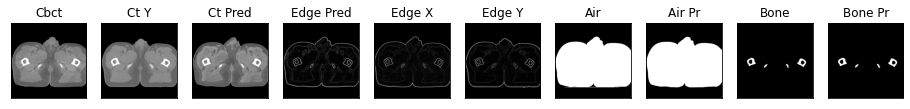

31it [00:12,  2.72it/s]

ssim score = 0.8312784433364868
psnr score = 24.643457412719727
snr score = 16.30487632751465
mae error = 0.028439683839678764
air dice score = 0.9977798077446611
bone dice score = 0.9691912708605713
contour dice score = 0.3406795263290405


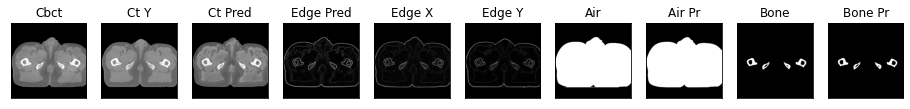

32it [00:12,  2.34it/s]

ssim score = 0.8302299380302429
psnr score = 24.646808624267578
snr score = 16.43637466430664
mae error = 0.02955339290201664
air dice score = 0.997958556898453
bone dice score = 0.9608009024258206
contour dice score = 0.3121226131916046


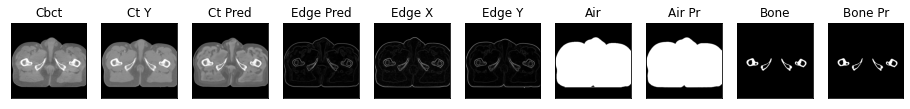

33it [00:13,  2.45it/s]

ssim score = 0.830518901348114
psnr score = 24.677616119384766
snr score = 16.570417404174805
mae error = 0.030843904241919518
air dice score = 0.9983508146975404
bone dice score = 0.9486796213260005
contour dice score = 0.32759422063827515


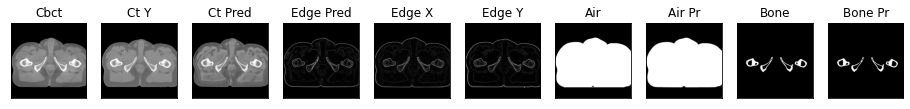

34it [00:13,  2.53it/s]

ssim score = 0.834365725517273
psnr score = 24.76480484008789
snr score = 16.72470474243164
mae error = 0.03155934065580368
air dice score = 0.9982376591334072
bone dice score = 0.9311307584931231
contour dice score = 0.31441861391067505


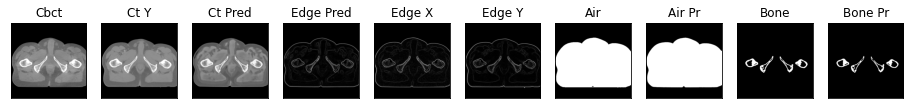

35it [00:13,  2.58it/s]

ssim score = 0.833782970905304
psnr score = 24.932723999023438
snr score = 16.882734298706055
mae error = 0.030997736379504204
air dice score = 0.9984396588689323
bone dice score = 0.9382526822866406
contour dice score = 0.3344140946865082


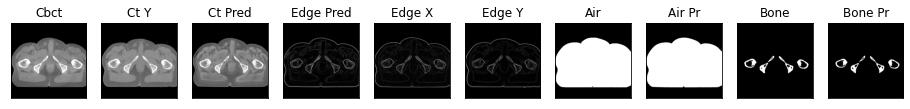

36it [00:14,  2.61it/s]

ssim score = 0.8385047316551208
psnr score = 25.13359832763672
snr score = 17.069948196411133
mae error = 0.030427077785134315
air dice score = 0.9983597009425786
bone dice score = 0.9465731246632858
contour dice score = 0.3253012001514435


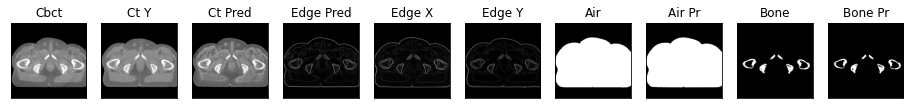

37it [00:14,  2.65it/s]

ssim score = 0.8461171984672546
psnr score = 25.320222854614258
snr score = 17.268571853637695
mae error = 0.030059954151511192
air dice score = 0.998480405541772
bone dice score = 0.9368251780388601
contour dice score = 0.34709978103637695


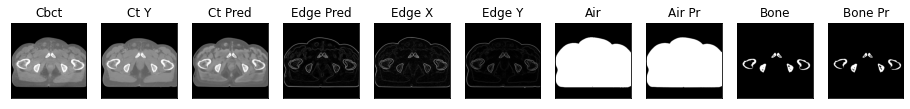

38it [00:15,  2.67it/s]

ssim score = 0.8467482924461365
psnr score = 25.158897399902344
snr score = 17.146331787109375
mae error = 0.030905706807971
air dice score = 0.9985761239721404
bone dice score = 0.9370645884999755
contour dice score = 0.34855544567108154


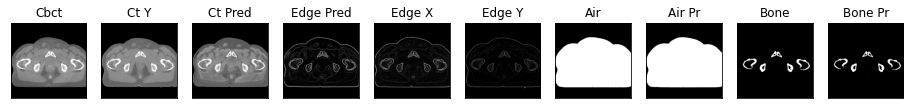

39it [00:15,  2.69it/s]

ssim score = 0.8393135666847229
psnr score = 24.438735961914062
snr score = 16.567461013793945
mae error = 0.03418892249464989
air dice score = 0.9985163028641298
bone dice score = 0.9157222336707632
contour dice score = 0.3275781571865082


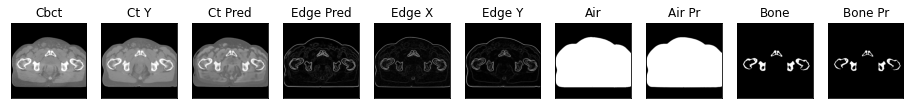

40it [00:15,  2.71it/s]

ssim score = 0.8383708596229553
psnr score = 24.104433059692383
snr score = 16.327842712402344
mae error = 0.03665359318256378
air dice score = 0.9983895600705989
bone dice score = 0.8871996505033883
contour dice score = 0.31539541482925415


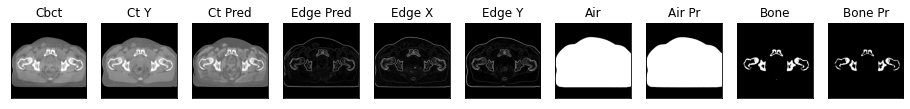

41it [00:16,  2.71it/s]

ssim score = 0.8302528262138367
psnr score = 23.631332397460938
snr score = 15.820694923400879
mae error = 0.037461742758750916
air dice score = 0.998372490923508
bone dice score = 0.8526645768037908
contour dice score = 0.3134678602218628


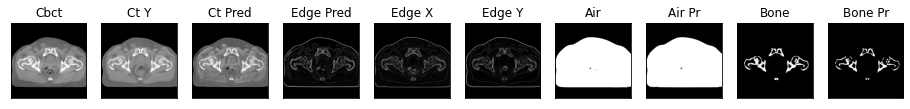

42it [00:16,  2.32it/s]

ssim score = 0.8301886916160583
psnr score = 22.842052459716797
snr score = 15.103601455688477
mae error = 0.04006366804242134
air dice score = 0.9978166724648821
bone dice score = 0.783290226508478
contour dice score = 0.3256470561027527


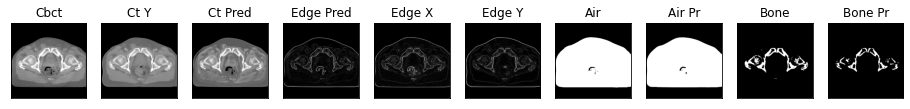

43it [00:17,  2.41it/s]

ssim score = 0.8302995562553406
psnr score = 23.212783813476562
snr score = 15.338237762451172
mae error = 0.03787326067686081
air dice score = 0.9981399772463247
bone dice score = 0.8385845855565819
contour dice score = 0.3218499422073364


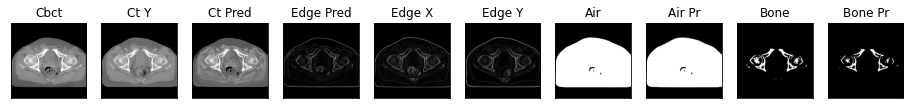

44it [00:17,  2.50it/s]

ssim score = 0.8347964882850647
psnr score = 23.759775161743164
snr score = 15.706670761108398
mae error = 0.03474675863981247
air dice score = 0.998382287252666
bone dice score = 0.8776857771734862
contour dice score = 0.3445338308811188


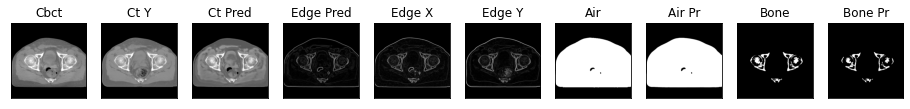

45it [00:17,  2.56it/s]

ssim score = 0.8336275219917297
psnr score = 24.01702117919922
snr score = 15.87332820892334
mae error = 0.03368721157312393
air dice score = 0.9984887502569134
bone dice score = 0.8887332165803999
contour dice score = 0.35361215472221375


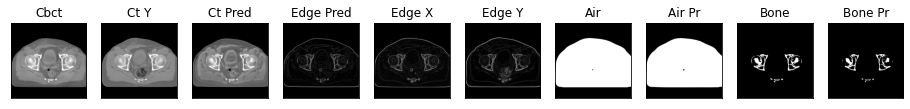

46it [00:18,  2.61it/s]

ssim score = 0.8324683904647827
psnr score = 23.957231521606445
snr score = 15.829225540161133
mae error = 0.033926982432603836
air dice score = 0.9984453944811513
bone dice score = 0.8862341078486822
contour dice score = 0.37100619077682495


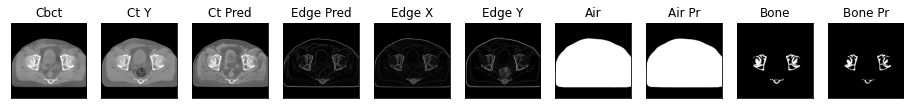

47it [00:18,  2.65it/s]

ssim score = 0.8203344941139221
psnr score = 23.681739807128906
snr score = 15.563773155212402
mae error = 0.03518498316407204
air dice score = 0.9983702121165888
bone dice score = 0.8932384341647565
contour dice score = 0.3688485324382782


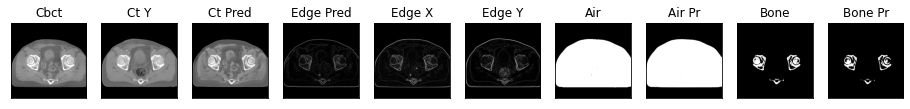

48it [00:18,  2.66it/s]

ssim score = 0.8263419270515442
psnr score = 23.89151382446289
snr score = 15.83513355255127
mae error = 0.03487847372889519
air dice score = 0.998278850688767
bone dice score = 0.8953667953678054
contour dice score = 0.37804296612739563


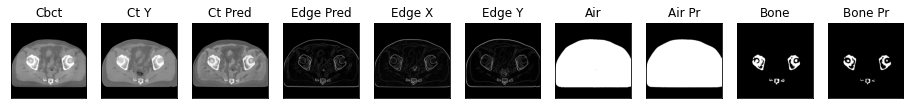

49it [00:19,  2.68it/s]

ssim score = 0.8278292417526245
psnr score = 24.0925235748291
snr score = 16.10622787475586
mae error = 0.03505486249923706
air dice score = 0.9978756323984491
bone dice score = 0.930228293756943
contour dice score = 0.33571767807006836


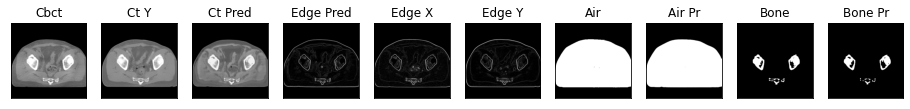

50it [00:19,  2.70it/s]

ssim score = 0.840549886226654
psnr score = 24.410263061523438
snr score = 16.304859161376953
mae error = 0.03298576921224594
air dice score = 0.9980230602045715
bone dice score = 0.9189909762108389
contour dice score = 0.36034318804740906


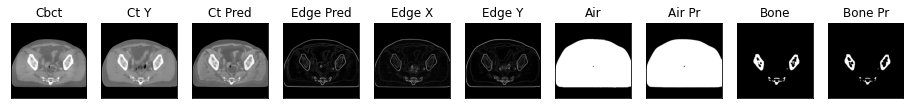

51it [00:20,  2.70it/s]

ssim score = 0.834256112575531
psnr score = 23.712127685546875
snr score = 15.68835163116455
mae error = 0.03528063744306564
air dice score = 0.9979143663354203
bone dice score = 0.9086811502757713
contour dice score = 0.3149832487106323


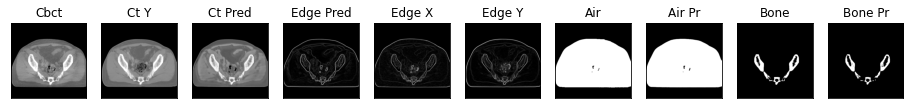

52it [00:20,  2.32it/s]

ssim score = 0.8378174901008606
psnr score = 23.632484436035156
snr score = 15.688854217529297
mae error = 0.03667248412966728
air dice score = 0.9973977626882046
bone dice score = 0.8746791131865058
contour dice score = 0.2899664044380188


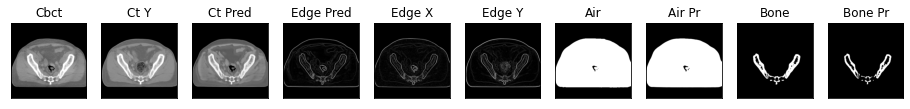

53it [00:20,  2.42it/s]

ssim score = 0.8200944066047668
psnr score = 23.079547882080078
snr score = 15.157476425170898
mae error = 0.038380272686481476
air dice score = 0.9975508309462603
bone dice score = 0.8526675677836315
contour dice score = 0.2755298614501953


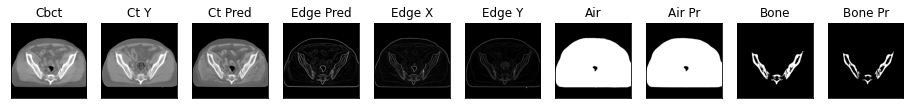

54it [00:21,  2.51it/s]

ssim score = 0.8198893070220947
psnr score = 23.49287986755371
snr score = 15.583345413208008
mae error = 0.03793993964791298
air dice score = 0.9976254512854077
bone dice score = 0.8693023625815822
contour dice score = 0.26057693362236023


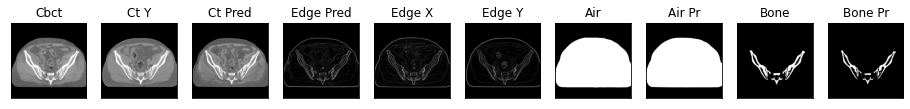

55it [00:21,  2.57it/s]

ssim score = 0.7798027396202087
psnr score = 20.81456756591797
snr score = 10.694771766662598
mae error = 0.03432539105415344
air dice score = 0.9971675944209677
bone dice score = 0.9462997595525968
contour dice score = 0.5445489883422852


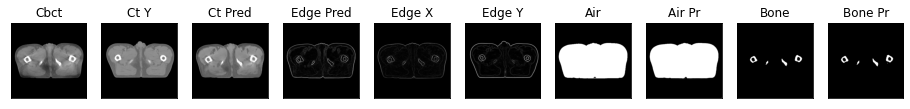

56it [00:22,  2.62it/s]

ssim score = 0.77094566822052
psnr score = 20.46431541442871
snr score = 10.557504653930664
mae error = 0.036635033786296844
air dice score = 0.9974951590840476
bone dice score = 0.929613189601995
contour dice score = 0.5107319951057434


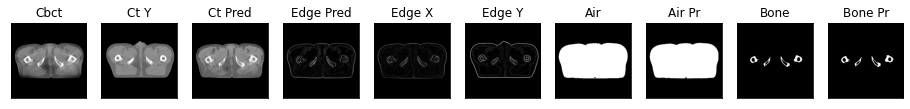

57it [00:22,  2.66it/s]

ssim score = 0.7672760486602783
psnr score = 20.392963409423828
snr score = 10.617292404174805
mae error = 0.03798887878656387
air dice score = 0.9976242835316061
bone dice score = 0.8975320829240369
contour dice score = 0.507953941822052


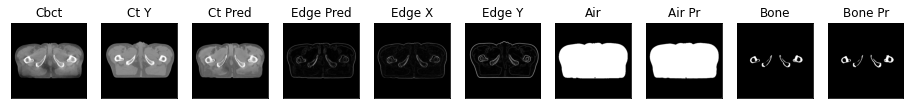

58it [00:22,  2.70it/s]

ssim score = 0.7694525718688965
psnr score = 20.59799575805664
snr score = 10.892725944519043
mae error = 0.037538353353738785
air dice score = 0.9970906470014352
bone dice score = 0.899943257047476
contour dice score = 0.4462719261646271


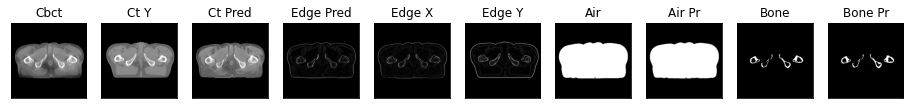

59it [00:23,  2.71it/s]

ssim score = 0.7672562003135681
psnr score = 20.664596557617188
snr score = 11.006893157958984
mae error = 0.037459805607795715
air dice score = 0.9971537915874862
bone dice score = 0.9055350553522964
contour dice score = 0.46673935651779175


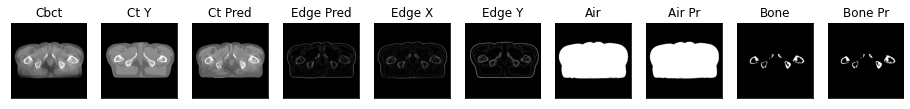

60it [00:23,  2.73it/s]

ssim score = 0.7639057040214539
psnr score = 20.766183853149414
snr score = 11.114096641540527
mae error = 0.037261009216308594
air dice score = 0.9968574870371367
bone dice score = 0.9152725310322851
contour dice score = 0.4384288787841797


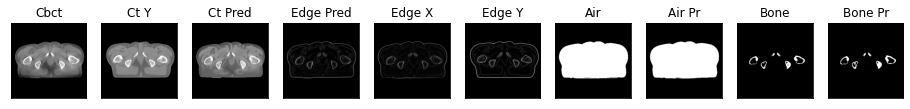

61it [00:23,  2.74it/s]

ssim score = 0.7637211084365845
psnr score = 20.800535202026367
snr score = 11.14194393157959
mae error = 0.037033576518297195
air dice score = 0.9961350974930395
bone dice score = 0.9171927218730562
contour dice score = 0.4819149076938629


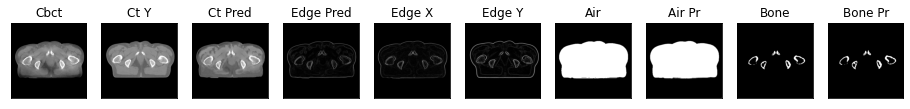

62it [00:24,  2.32it/s]

ssim score = 0.7654800415039062
psnr score = 20.689327239990234
snr score = 11.044845581054688
mae error = 0.0374913364648819
air dice score = 0.99660769904825
bone dice score = 0.9256868891771033
contour dice score = 0.4099840819835663


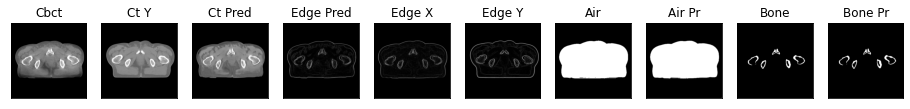

63it [00:24,  2.44it/s]

ssim score = 0.7649220824241638
psnr score = 20.576465606689453
snr score = 10.989992141723633
mae error = 0.03903202712535858
air dice score = 0.9965139269485618
bone dice score = 0.9199537877550759
contour dice score = 0.48158034682273865


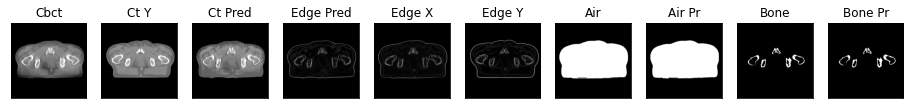

64it [00:25,  2.52it/s]

ssim score = 0.7550990581512451
psnr score = 20.393028259277344
snr score = 10.905113220214844
mae error = 0.04105522856116295
air dice score = 0.9967839543529032
bone dice score = 0.904892130053101
contour dice score = 0.46275752782821655


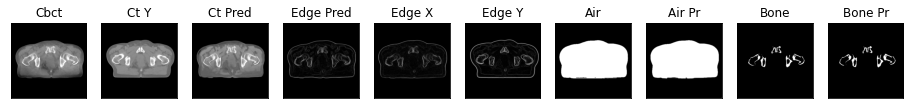

65it [00:25,  2.59it/s]

ssim score = 0.7470490336418152
psnr score = 20.193593978881836
snr score = 10.741506576538086
mae error = 0.04283936694264412
air dice score = 0.9965225344942172
bone dice score = 0.911876276628073
contour dice score = 0.43931257724761963


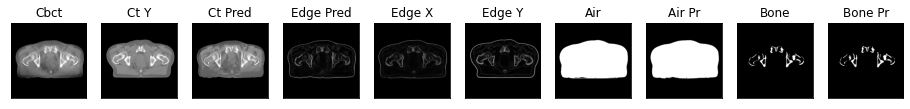

66it [00:25,  2.64it/s]

ssim score = 0.7411063313484192
psnr score = 20.102741241455078
snr score = 10.68336296081543
mae error = 0.043164655566215515
air dice score = 0.9969055725552757
bone dice score = 0.885387205388749
contour dice score = 0.4574183225631714


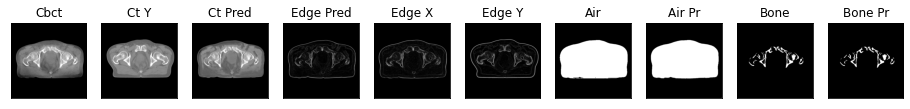

67it [00:26,  2.67it/s]

ssim score = 0.741132378578186
psnr score = 20.18211555480957
snr score = 10.87955379486084
mae error = 0.043002236634492874
air dice score = 0.9970176013239808
bone dice score = 0.9038291419195775
contour dice score = 0.5079197287559509


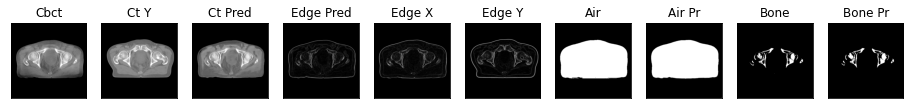

68it [00:26,  2.70it/s]

ssim score = 0.7444605231285095
psnr score = 20.28594207763672
snr score = 10.967395782470703
mae error = 0.04193587973713875
air dice score = 0.9973278165675395
bone dice score = 0.885818772858109
contour dice score = 0.4594447612762451


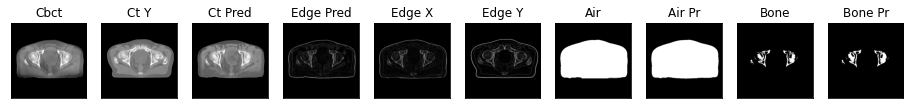

69it [00:27,  2.71it/s]

ssim score = 0.7580797672271729
psnr score = 20.854738235473633
snr score = 11.337023735046387
mae error = 0.03794549033045769
air dice score = 0.9970613328277588
bone dice score = 0.9054172767217362
contour dice score = 0.4449220895767212


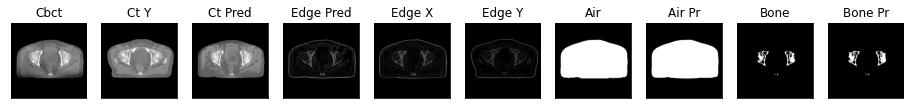

70it [00:27,  2.73it/s]

ssim score = 0.7735115885734558
psnr score = 21.53842544555664
snr score = 11.850319862365723
mae error = 0.03456556424498558
air dice score = 0.9969450539994003
bone dice score = 0.9265027322414412
contour dice score = 0.43211206793785095


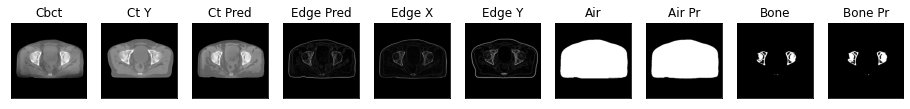

71it [00:27,  2.74it/s]

ssim score = 0.7805389165878296
psnr score = 21.929471969604492
snr score = 12.255535125732422
mae error = 0.033240702003240585
air dice score = 0.9970463990108897
bone dice score = 0.946630307752933
contour dice score = 0.4671298861503601


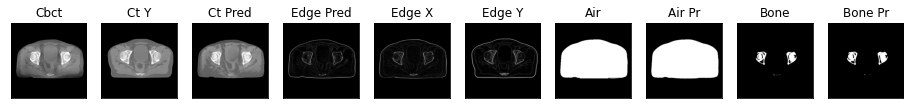

72it [00:28,  2.33it/s]

ssim score = 0.7812970280647278
psnr score = 22.059432983398438
snr score = 12.467326164245605
mae error = 0.033144429326057434
air dice score = 0.9972507472657378
bone dice score = 0.9464998669158038
contour dice score = 0.46771568059921265


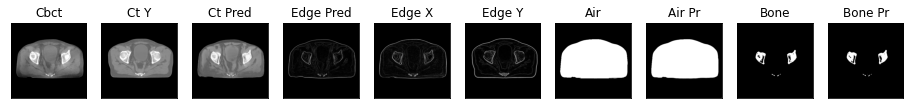

73it [00:28,  2.44it/s]

ssim score = 0.7800094485282898
psnr score = 22.02284049987793
snr score = 12.522906303405762
mae error = 0.03327029570937157
air dice score = 0.997464031080564
bone dice score = 0.9375645756466781
contour dice score = 0.4424876272678375


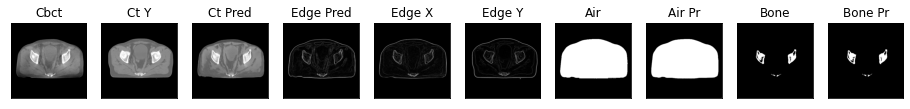

74it [00:29,  2.53it/s]

ssim score = 0.7775534391403198
psnr score = 22.2794246673584
snr score = 12.716063499450684
mae error = 0.03250300884246826
air dice score = 0.9973715773088037
bone dice score = 0.9473173884947105
contour dice score = 0.4659152030944824


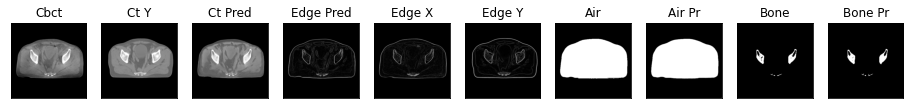

75it [00:29,  2.59it/s]

ssim score = 0.7834641933441162
psnr score = 22.41586685180664
snr score = 12.816112518310547
mae error = 0.031441643834114075
air dice score = 0.9970752278601576
bone dice score = 0.9413407821239291
contour dice score = 0.4317697286605835


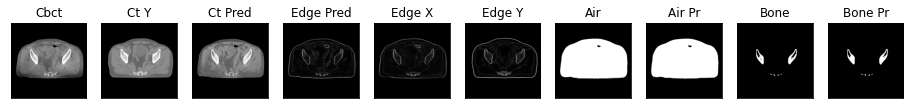

76it [00:29,  2.64it/s]

ssim score = 0.781425416469574
psnr score = 22.02237892150879
snr score = 12.460370063781738
mae error = 0.03380829840898514
air dice score = 0.9969558858542252
bone dice score = 0.9221808768820227
contour dice score = 0.4466843605041504


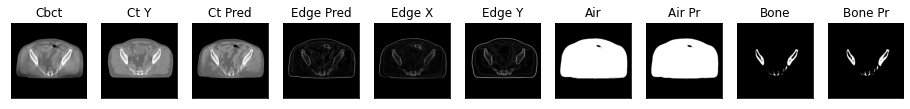

77it [00:30,  2.68it/s]

ssim score = 0.7785124778747559
psnr score = 21.837778091430664
snr score = 12.40627384185791
mae error = 0.035463597625494
air dice score = 0.996885636487409
bone dice score = 0.9283029777402674
contour dice score = 0.5045430064201355


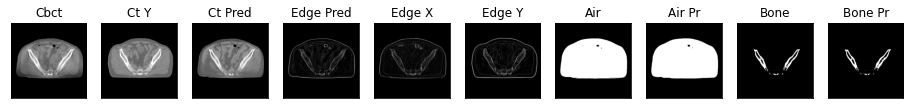

78it [00:30,  2.70it/s]

ssim score = 0.783396303653717
psnr score = 21.67483139038086
snr score = 12.261075019836426
mae error = 0.0358056016266346
air dice score = 0.9969855597209321
bone dice score = 0.906925031767679
contour dice score = 0.48576033115386963


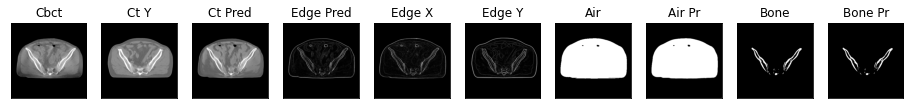

79it [00:30,  2.72it/s]

ssim score = 0.7801079750061035
psnr score = 21.962936401367188
snr score = 12.537910461425781
mae error = 0.03513067588210106
air dice score = 0.9970838979707386
bone dice score = 0.9098901098916333
contour dice score = 0.5205183625221252


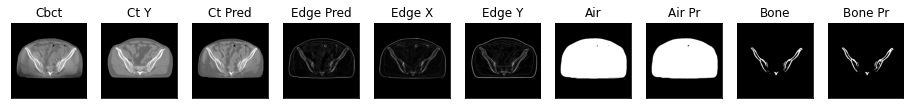

80it [00:31,  2.73it/s]

ssim score = 0.7828927636146545
psnr score = 22.053157806396484
snr score = 12.627392768859863
mae error = 0.0346011184155941
air dice score = 0.9968926723878248
bone dice score = 0.9039053637999691
contour dice score = 0.4926430583000183


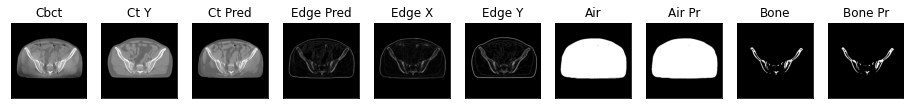

81it [00:31,  2.74it/s]

ssim score = 0.8230809569358826
psnr score = 23.260589599609375
snr score = 13.694723129272461
mae error = 0.02409125119447708
air dice score = 0.9960587831692521
bone dice score = 0.9145728643246743
contour dice score = 0.3732767701148987


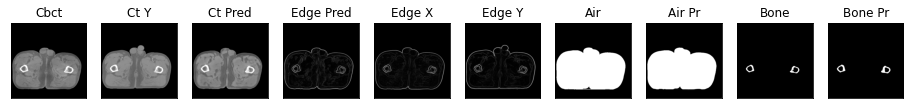

82it [00:32,  2.34it/s]

ssim score = 0.8209782242774963
psnr score = 23.417997360229492
snr score = 13.916522026062012
mae error = 0.024588661268353462
air dice score = 0.9962838828274214
bone dice score = 0.9054142204857987
contour dice score = 0.334209144115448


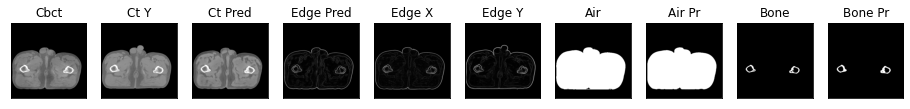

83it [00:32,  2.45it/s]

ssim score = 0.8301735520362854
psnr score = 24.420028686523438
snr score = 15.05776596069336
mae error = 0.02451353706419468
air dice score = 0.9968597047652634
bone dice score = 0.9238424924291683
contour dice score = 0.3855544328689575


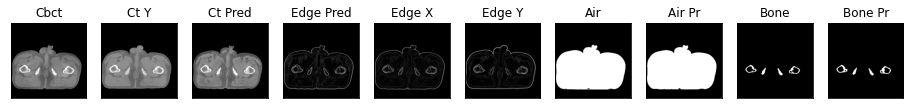

84it [00:32,  2.53it/s]

ssim score = 0.8272794485092163
psnr score = 24.344802856445312
snr score = 15.104031562805176
mae error = 0.025712037459015846
air dice score = 0.9975929892891937
bone dice score = 0.9091659785320155
contour dice score = 0.4047373831272125


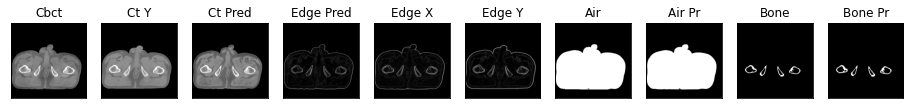

85it [00:33,  2.59it/s]

ssim score = 0.8224449157714844
psnr score = 24.202533721923828
snr score = 14.98593521118164
mae error = 0.02630246989428997
air dice score = 0.9977388750320538
bone dice score = 0.8961337513083357
contour dice score = 0.4288681149482727


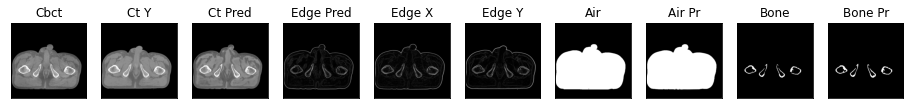

86it [00:33,  2.64it/s]

ssim score = 0.8177393674850464
psnr score = 23.995620727539062
snr score = 14.774628639221191
mae error = 0.027021953836083412
air dice score = 0.9978347755228762
bone dice score = 0.8923018581742074
contour dice score = 0.40690377354621887


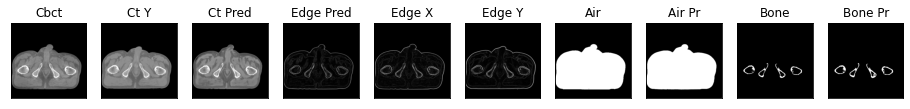

87it [00:33,  2.68it/s]

ssim score = 0.8196159601211548
psnr score = 23.75401496887207
snr score = 14.539276123046875
mae error = 0.027529265731573105
air dice score = 0.9975097167593754
bone dice score = 0.9076427081375376
contour dice score = 0.3682272434234619


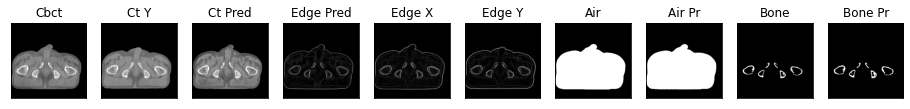

88it [00:34,  2.69it/s]

ssim score = 0.821806013584137
psnr score = 23.65591812133789
snr score = 14.419622421264648
mae error = 0.027569221332669258
air dice score = 0.9974447991177199
bone dice score = 0.9244085401053201
contour dice score = 0.39978957176208496


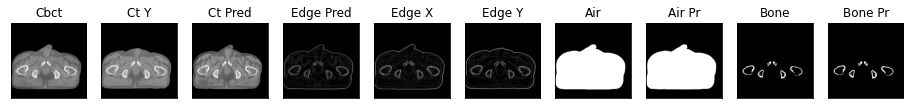

89it [00:34,  2.69it/s]

ssim score = 0.8225771188735962
psnr score = 23.576509475708008
snr score = 14.357126235961914
mae error = 0.027981897816061974
air dice score = 0.9973288060619769
bone dice score = 0.9359970403267481
contour dice score = 0.4069952368736267


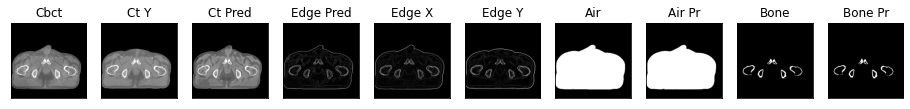

90it [00:35,  2.70it/s]

ssim score = 0.8243116736412048
psnr score = 23.657188415527344
snr score = 14.506397247314453
mae error = 0.028450962156057358
air dice score = 0.9975534451088462
bone dice score = 0.934006734007845
contour dice score = 0.438400000333786


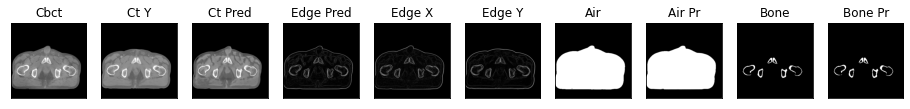

91it [00:35,  2.71it/s]

ssim score = 0.821689248085022
psnr score = 23.66115379333496
snr score = 14.591720581054688
mae error = 0.029417356476187706
air dice score = 0.9979522184300358
bone dice score = 0.9340132900643794
contour dice score = 0.46236559748649597


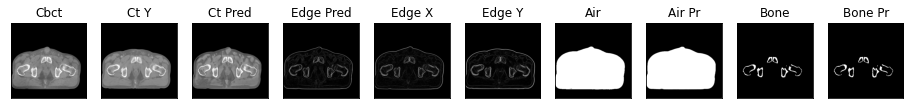

92it [00:36,  2.33it/s]

ssim score = 0.8234149813652039
psnr score = 23.69765853881836
snr score = 14.678927421569824
mae error = 0.03020963817834854
air dice score = 0.9981958417698097
bone dice score = 0.918983202022908
contour dice score = 0.48116254806518555


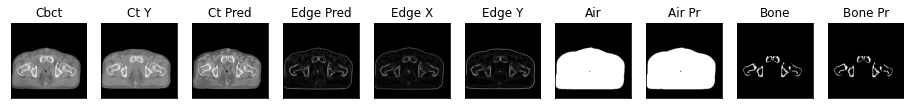

93it [00:36,  2.43it/s]

ssim score = 0.8257259726524353
psnr score = 23.72275161743164
snr score = 14.820290565490723
mae error = 0.031121062114834785
air dice score = 0.9983171234662529
bone dice score = 0.8827310384247574
contour dice score = 0.47311827540397644


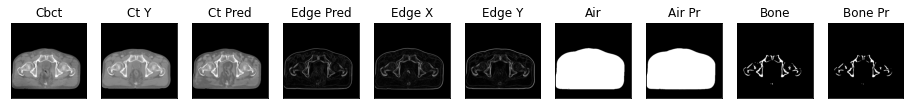

94it [00:36,  2.52it/s]

ssim score = 0.8261646032333374
psnr score = 23.568927764892578
snr score = 14.628230094909668
mae error = 0.030800849199295044
air dice score = 0.998451582165404
bone dice score = 0.8934401899689308
contour dice score = 0.48625338077545166


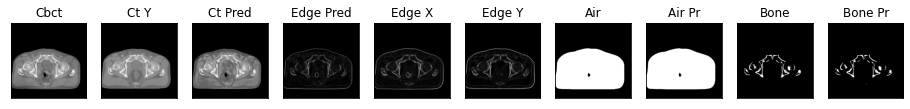

95it [00:37,  2.58it/s]

ssim score = 0.8189881443977356
psnr score = 23.094261169433594
snr score = 14.057892799377441
mae error = 0.031124629080295563
air dice score = 0.9973731840533072
bone dice score = 0.9071082390965656
contour dice score = 0.42031335830688477


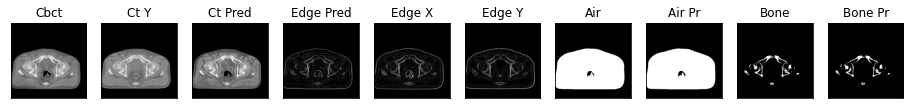

96it [00:37,  2.63it/s]

ssim score = 0.825549304485321
psnr score = 23.20319366455078
snr score = 14.007068634033203
mae error = 0.02921580709517002
air dice score = 0.9976049739127649
bone dice score = 0.8841680880774667
contour dice score = 0.40606388449668884


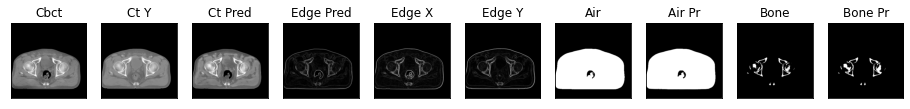

97it [00:37,  2.67it/s]

ssim score = 0.8260489106178284
psnr score = 23.09187126159668
snr score = 13.779319763183594
mae error = 0.028668679296970367
air dice score = 0.9972202068948673
bone dice score = 0.8797348484867467
contour dice score = 0.311956524848938


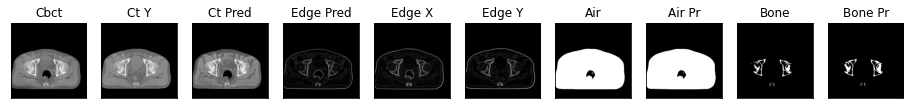

98it [00:38,  2.69it/s]

ssim score = 0.8222585916519165
psnr score = 23.086544036865234
snr score = 13.728896141052246
mae error = 0.0285210981965065
air dice score = 0.9974652393257065
bone dice score = 0.9087591240889787
contour dice score = 0.35114502906799316


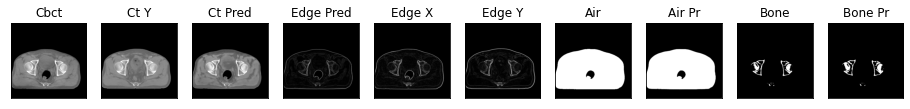

99it [00:38,  2.71it/s]

ssim score = 0.8188162446022034
psnr score = 22.666013717651367
snr score = 13.315040588378906
mae error = 0.030129270628094673
air dice score = 0.9974034084372813
bone dice score = 0.9272362119584855
contour dice score = 0.35866594314575195


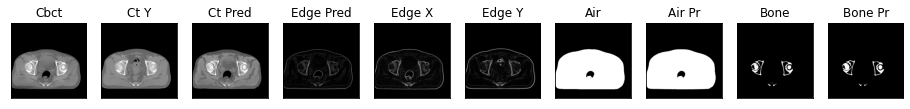

100it [00:38,  2.73it/s]

ssim score = 0.8206906318664551
psnr score = 22.441123962402344
snr score = 13.120254516601562
mae error = 0.031085601076483727
air dice score = 0.9973652576284047
bone dice score = 0.9428399518660824
contour dice score = 0.365626722574234


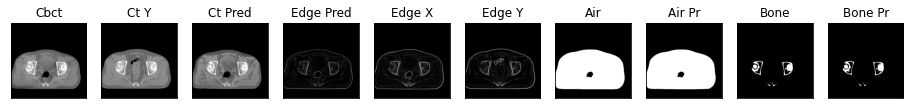

101it [00:39,  2.73it/s]

ssim score = 0.8270931839942932
psnr score = 23.02222442626953
snr score = 13.658771514892578
mae error = 0.02891845814883709
air dice score = 0.9968917029849544
bone dice score = 0.9331997328000468
contour dice score = 0.3561643958091736


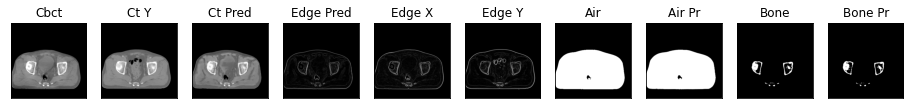

102it [00:39,  2.34it/s]

ssim score = 0.8332481980323792
psnr score = 23.50673484802246
snr score = 14.05307388305664
mae error = 0.026727082207798958
air dice score = 0.9968535539974755
bone dice score = 0.9230769230783319
contour dice score = 0.3662280738353729


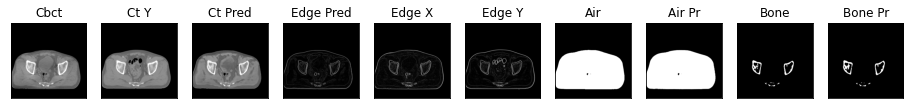

103it [00:40,  2.45it/s]

ssim score = 0.8356272578239441
psnr score = 23.272363662719727
snr score = 13.752979278564453
mae error = 0.026559889316558838
air dice score = 0.9969377112103158
bone dice score = 0.9422135161617587
contour dice score = 0.39340659976005554


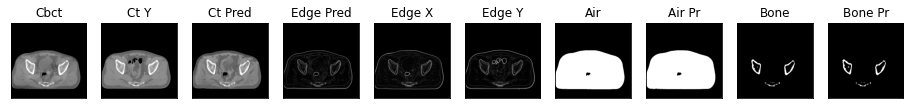

104it [00:40,  2.53it/s]

ssim score = 0.8352462649345398
psnr score = 23.297866821289062
snr score = 13.778180122375488
mae error = 0.026728972792625427
air dice score = 0.9966207128446565
bone dice score = 0.94674761491853
contour dice score = 0.40748897194862366


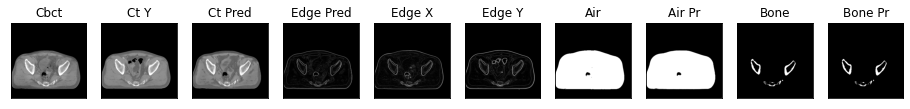

105it [00:40,  2.59it/s]

ssim score = 0.8289125561714172
psnr score = 23.097352981567383
snr score = 13.653831481933594
mae error = 0.028368063271045685
air dice score = 0.9970739154403994
bone dice score = 0.9301106581256536
contour dice score = 0.4475138187408447


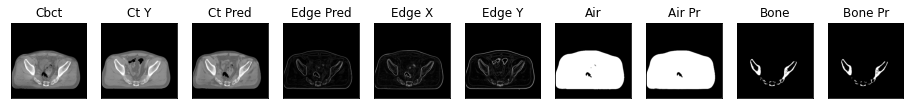

106it [00:41,  2.63it/s]

ssim score = 0.8297809362411499
psnr score = 23.051464080810547
snr score = 13.643527030944824
mae error = 0.02898351289331913
air dice score = 0.9971310985501826
bone dice score = 0.9096218020034813
contour dice score = 0.4486187696456909


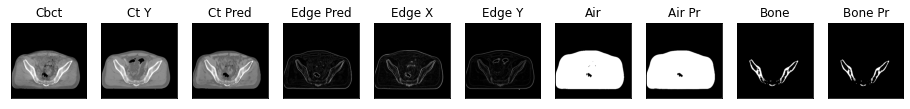

107it [00:41,  2.66it/s]

ssim score = 0.8346254229545593
psnr score = 23.753868103027344
snr score = 14.284231185913086
mae error = 0.027013367041945457
air dice score = 0.997511242319181
bone dice score = 0.9041375291389258
contour dice score = 0.3815862536430359


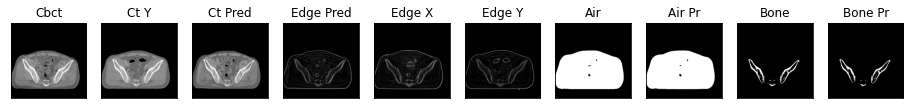

108it [00:42,  2.69it/s]

ssim score = 0.8285515308380127
psnr score = 23.470989227294922
snr score = 13.940091133117676
mae error = 0.027724025771021843
air dice score = 0.9971713047465012
bone dice score = 0.8943630043842472
contour dice score = 0.3536653518676758


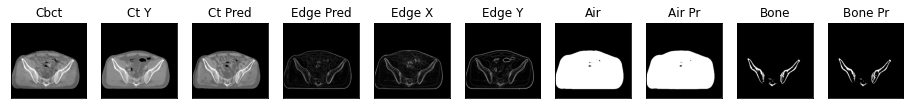

109it [00:42,  2.70it/s]

ssim score = 0.7551620602607727
psnr score = 21.603975296020508
snr score = 13.301281929016113
mae error = 0.03796364367008209
air dice score = 0.9977018302434415
bone dice score = 0.960465828992937
contour dice score = 0.3701413571834564


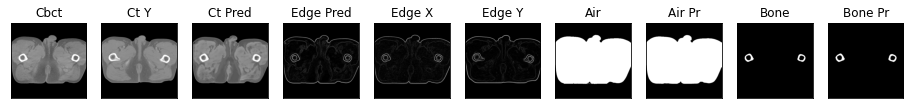

110it [00:42,  2.72it/s]

ssim score = 0.7465654611587524
psnr score = 21.247074127197266
snr score = 13.04867172241211
mae error = 0.04047640040516853
air dice score = 0.997985984335435
bone dice score = 0.9593629873706929
contour dice score = 0.3932384252548218


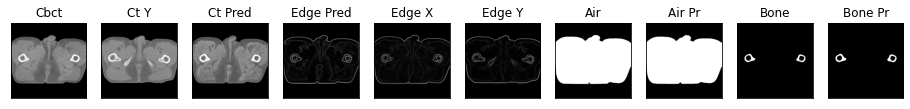

111it [00:43,  2.72it/s]

ssim score = 0.7403688430786133
psnr score = 20.848285675048828
snr score = 12.777839660644531
mae error = 0.043939486145973206
air dice score = 0.998086854460095
bone dice score = 0.9342906875558248
contour dice score = 0.36599552631378174


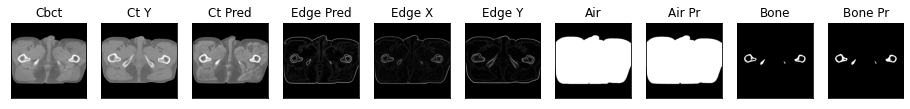

112it [00:43,  2.33it/s]

ssim score = 0.7325170040130615
psnr score = 20.424192428588867
snr score = 12.386035919189453
mae error = 0.046726126223802567
air dice score = 0.9979281040396131
bone dice score = 0.9515151515159678
contour dice score = 0.3631460666656494


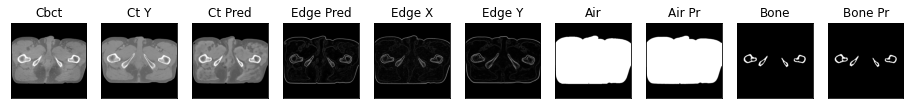

113it [00:44,  2.44it/s]

ssim score = 0.718782365322113
psnr score = 20.26350212097168
snr score = 12.255584716796875
mae error = 0.0477663055062294
air dice score = 0.9980216278676195
bone dice score = 0.9302478253745241
contour dice score = 0.3673285245895386


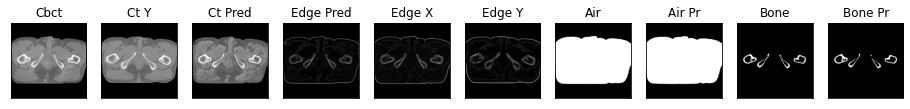

114it [00:44,  2.52it/s]

ssim score = 0.71373450756073
psnr score = 20.173675537109375
snr score = 12.200175285339355
mae error = 0.049089331179857254
air dice score = 0.9980510905166657
bone dice score = 0.9377945334599781
contour dice score = 0.3775971233844757


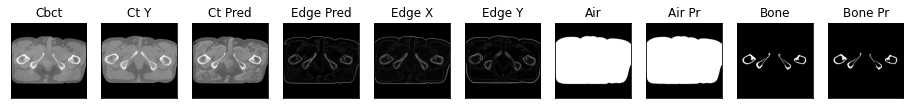

115it [00:44,  2.57it/s]

ssim score = 0.7048537135124207
psnr score = 19.920970916748047
snr score = 11.967779159545898
mae error = 0.05074545368552208
air dice score = 0.9979599879453845
bone dice score = 0.9322152341029739
contour dice score = 0.3794502019882202


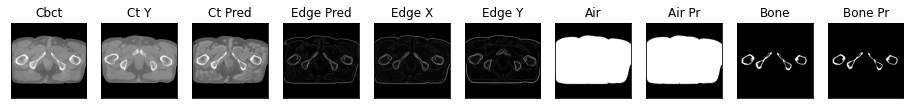

116it [00:45,  2.61it/s]

ssim score = 0.701248288154602
psnr score = 19.853158950805664
snr score = 11.939040184020996
mae error = 0.05138546973466873
air dice score = 0.997395923752649
bone dice score = 0.9302844394878655
contour dice score = 0.41147467494010925


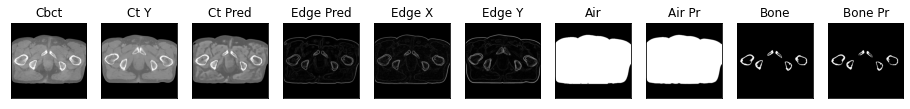

117it [00:45,  2.65it/s]

ssim score = 0.7052482962608337
psnr score = 19.89342498779297
snr score = 12.027986526489258
mae error = 0.051761284470558167
air dice score = 0.9966956592188813
bone dice score = 0.9266030013652578
contour dice score = 0.4039965271949768


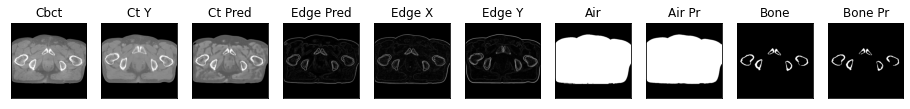

118it [00:45,  2.68it/s]

ssim score = 0.6999130249023438
psnr score = 19.656719207763672
snr score = 11.813892364501953
mae error = 0.05398093909025192
air dice score = 0.9969054573849687
bone dice score = 0.9184025474337482
contour dice score = 0.40781646966934204


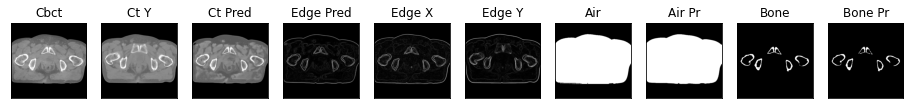

119it [00:46,  2.69it/s]

ssim score = 0.6882765889167786
psnr score = 19.58570671081543
snr score = 11.785658836364746
mae error = 0.055846646428108215
air dice score = 0.9974720657493781
bone dice score = 0.9076425192941543
contour dice score = 0.38877072930336


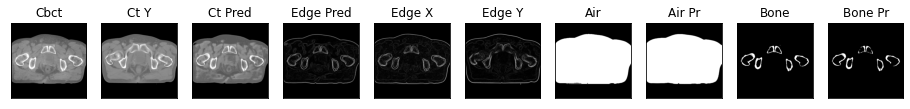

120it [00:46,  2.70it/s]

ssim score = 0.683760404586792
psnr score = 19.527557373046875
snr score = 11.785845756530762
mae error = 0.05643557757139206
air dice score = 0.9975381075639934
bone dice score = 0.9087184156623181
contour dice score = 0.3782312870025635


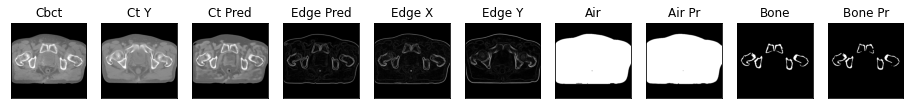

121it [00:46,  2.72it/s]

ssim score = 0.6837524175643921
psnr score = 19.51651954650879
snr score = 11.699437141418457
mae error = 0.056406546384096146
air dice score = 0.9981729598051168
bone dice score = 0.8668956633762677
contour dice score = 0.37574100494384766


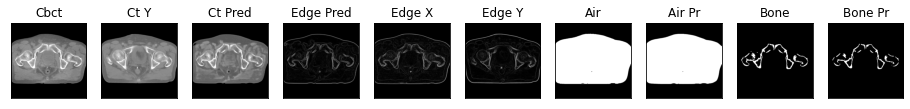

122it [00:47,  2.32it/s]

ssim score = 0.6845823526382446
psnr score = 19.654443740844727
snr score = 11.730141639709473
mae error = 0.05483727902173996
air dice score = 0.9981156789300744
bone dice score = 0.8495274503573375
contour dice score = 0.3668801486492157


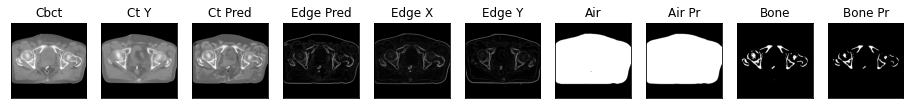

123it [00:47,  2.44it/s]

ssim score = 0.6978417634963989
psnr score = 20.08248519897461
snr score = 12.035097122192383
mae error = 0.05113609507679939
air dice score = 0.998303359348491
bone dice score = 0.8124730254659853
contour dice score = 0.38532111048698425


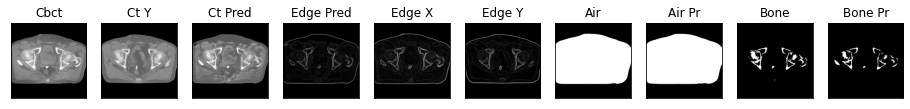

124it [00:48,  2.51it/s]

ssim score = 0.7070508599281311
psnr score = 20.36856460571289
snr score = 12.208745956420898
mae error = 0.048750247806310654
air dice score = 0.9984778773307512
bone dice score = 0.88769824260729
contour dice score = 0.4040590524673462


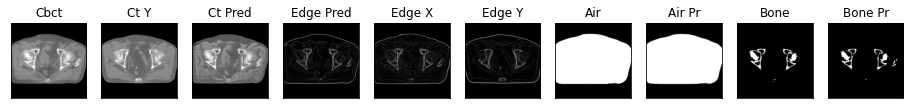

125it [00:48,  2.58it/s]

ssim score = 0.7018325924873352
psnr score = 20.574626922607422
snr score = 12.364163398742676
mae error = 0.046302832663059235
air dice score = 0.9984565314156564
bone dice score = 0.9322775578252523
contour dice score = 0.4001852571964264


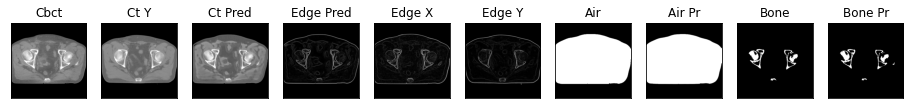

126it [00:49,  2.62it/s]

ssim score = 0.6997384428977966
psnr score = 20.40151596069336
snr score = 12.223204612731934
mae error = 0.04797384887933731
air dice score = 0.9984567901234577
bone dice score = 0.9296086908332822
contour dice score = 0.39832478761672974


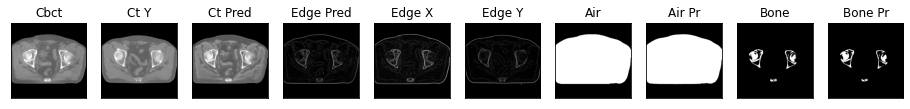

127it [00:49,  2.66it/s]

ssim score = 0.6997113823890686
psnr score = 20.188289642333984
snr score = 12.023454666137695
mae error = 0.04936952516436577
air dice score = 0.9983690587138873
bone dice score = 0.9383181979014232
contour dice score = 0.38014981150627136


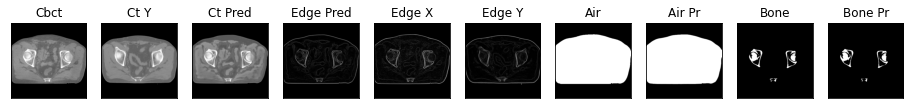

128it [00:49,  2.68it/s]

ssim score = 0.6987633109092712
psnr score = 19.843700408935547
snr score = 11.537376403808594
mae error = 0.05105315521359444
air dice score = 0.9981850754657341
bone dice score = 0.9396469465656052
contour dice score = 0.38059350848197937


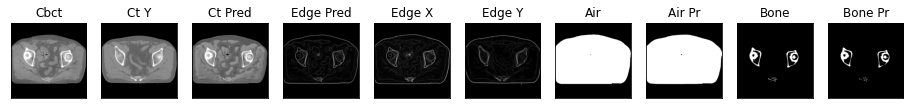

129it [00:50,  2.70it/s]

ssim score = 0.7112711071968079
psnr score = 19.92523765563965
snr score = 11.559605598449707
mae error = 0.04987408593297005
air dice score = 0.9984112974404246
bone dice score = 0.9445829869777697
contour dice score = 0.3892045319080353


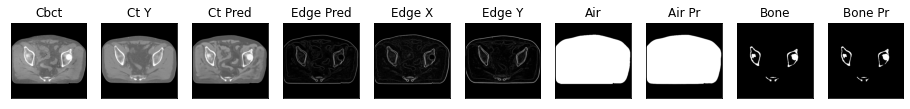

130it [00:50,  2.72it/s]

ssim score = 0.7094305753707886
psnr score = 20.24307632446289
snr score = 11.903091430664062
mae error = 0.04759102687239647
air dice score = 0.9983385463167178
bone dice score = 0.922992299231335
contour dice score = 0.3799147307872772


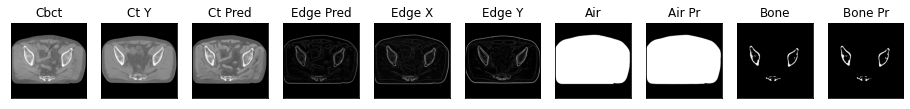

131it [00:50,  2.73it/s]

ssim score = 0.7046676278114319
psnr score = 20.078227996826172
snr score = 11.811056137084961
mae error = 0.04871223494410515
air dice score = 0.9978128565994687
bone dice score = 0.9365024288699427
contour dice score = 0.38957345485687256


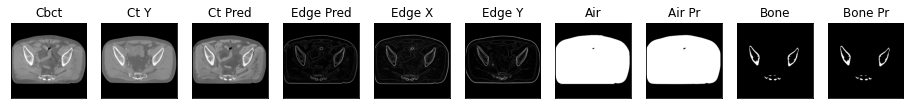

132it [00:51,  2.33it/s]

ssim score = 0.700690507888794
psnr score = 19.69788360595703
snr score = 11.559940338134766
mae error = 0.051110055297613144
air dice score = 0.9980027268160846
bone dice score = 0.9309150865633814
contour dice score = 0.37404578924179077


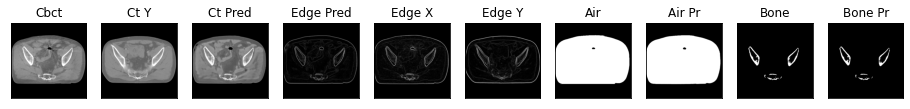

133it [00:51,  2.44it/s]

ssim score = 0.6963000893592834
psnr score = 19.513673782348633
snr score = 11.40969181060791
mae error = 0.052492640912532806
air dice score = 0.9978762446229295
bone dice score = 0.9301829268303325
contour dice score = 0.3765609860420227


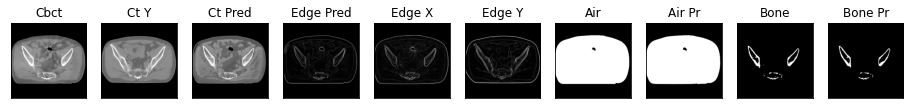

134it [00:52,  2.52it/s]

ssim score = 0.6853981018066406
psnr score = 19.49856948852539
snr score = 11.364795684814453
mae error = 0.05348845571279526
air dice score = 0.9978888701232913
bone dice score = 0.8990755007717119
contour dice score = 0.3765045702457428


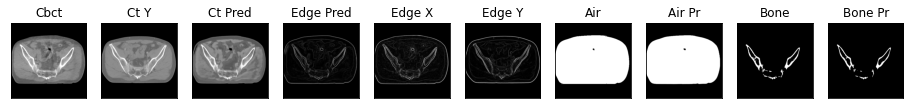

135it [00:52,  2.58it/s]

ssim score = 0.681601345539093
psnr score = 19.741914749145508
snr score = 11.544767379760742
mae error = 0.05238554626703262
air dice score = 0.9978826376285554
bone dice score = 0.8751390433832712
contour dice score = 0.40309327840805054


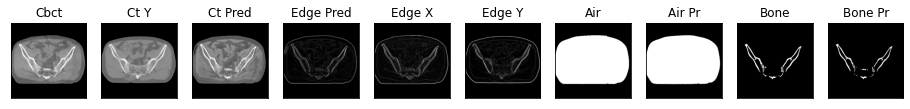

136it [00:52,  2.63it/s]

ssim score = 0.7757494449615479
psnr score = 21.41557502746582
snr score = 12.892965316772461
mae error = 0.0410592146217823
air dice score = 0.9977805325237366
bone dice score = 0.9136262099787339
contour dice score = 0.3738693594932556


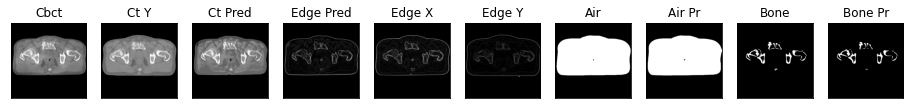

137it [00:53,  2.66it/s]

ssim score = 0.7821478843688965
psnr score = 21.494407653808594
snr score = 13.011810302734375
mae error = 0.04097830131649971
air dice score = 0.9978057289071058
bone dice score = 0.9089278852323693
contour dice score = 0.362443208694458


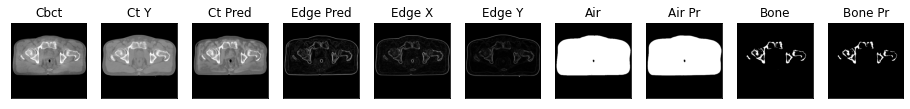

138it [00:53,  2.69it/s]

ssim score = 0.7818713188171387
psnr score = 21.586339950561523
snr score = 13.111528396606445
mae error = 0.04079659283161163
air dice score = 0.9980124907882313
bone dice score = 0.9048507462699247
contour dice score = 0.31018751859664917


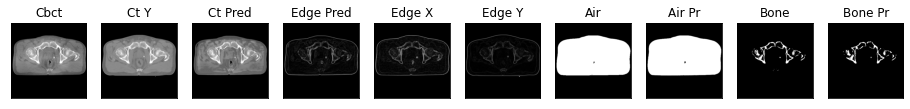

139it [00:53,  2.71it/s]

ssim score = 0.7854594588279724
psnr score = 21.649568557739258
snr score = 13.116338729858398
mae error = 0.03993191570043564
air dice score = 0.9980507404945607
bone dice score = 0.9118623232954903
contour dice score = 0.3605891168117523


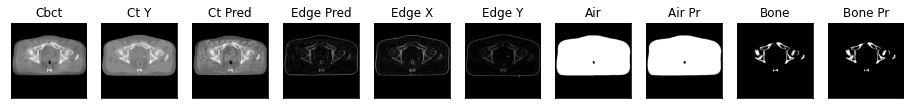

140it [00:54,  2.72it/s]

ssim score = 0.7909544110298157
psnr score = 21.94704246520996
snr score = 13.25818920135498
mae error = 0.03702052682638168
air dice score = 0.9980293573307173
bone dice score = 0.8994032395581216
contour dice score = 0.38653749227523804


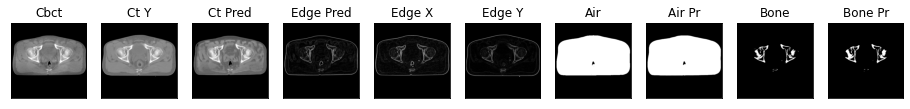

141it [00:54,  2.73it/s]

ssim score = 0.794577956199646
psnr score = 22.07648468017578
snr score = 13.366827011108398
mae error = 0.03632970526814461
air dice score = 0.9980848235408999
bone dice score = 0.9250407387299696
contour dice score = 0.39611053466796875


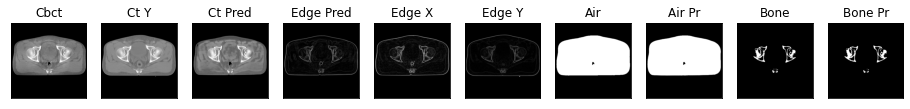

142it [00:55,  2.32it/s]

ssim score = 0.7920665740966797
psnr score = 21.993549346923828
snr score = 13.268261909484863
mae error = 0.03679388388991356
air dice score = 0.9977392614920891
bone dice score = 0.9284070916236513
contour dice score = 0.3940482437610626


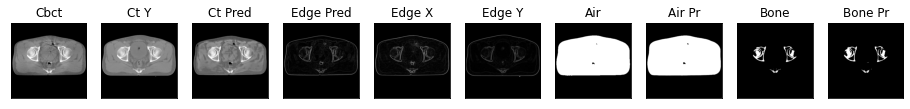

143it [00:55,  2.43it/s]

ssim score = 0.7817724347114563
psnr score = 21.561153411865234
snr score = 12.845230102539062
mae error = 0.038353707641363144
air dice score = 0.9977216128861354
bone dice score = 0.9250372780273142
contour dice score = 0.4224626421928406


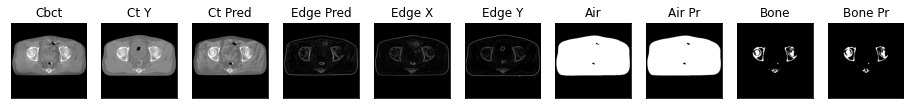

144it [00:56,  2.52it/s]

ssim score = 0.7816618084907532
psnr score = 21.480873107910156
snr score = 12.820731163024902
mae error = 0.039468683302402496
air dice score = 0.9975591267434828
bone dice score = 0.9384243076104003
contour dice score = 0.35573941469192505


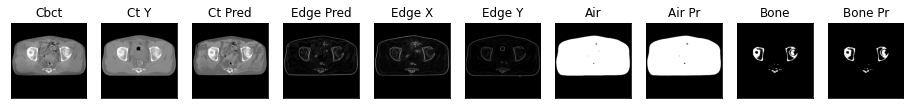

145it [00:56,  2.58it/s]

ssim score = 0.7814354300498962
psnr score = 21.282981872558594
snr score = 12.600913047790527
mae error = 0.04011857509613037
air dice score = 0.9974482217533402
bone dice score = 0.9435280961707642
contour dice score = 0.36571428179740906


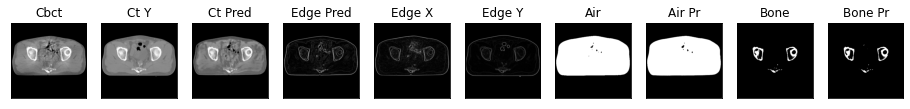

146it [00:56,  2.63it/s]

ssim score = 0.7810683250427246
psnr score = 20.99435043334961
snr score = 12.24150562286377
mae error = 0.04006310924887657
air dice score = 0.9975082167698559
bone dice score = 0.927000610874664
contour dice score = 0.33907145261764526


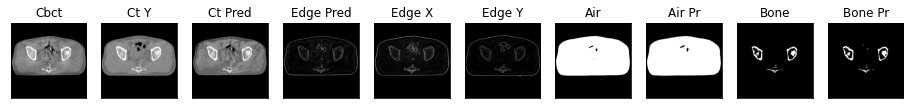

147it [00:57,  2.67it/s]

ssim score = 0.7824376821517944
psnr score = 21.192272186279297
snr score = 12.395533561706543
mae error = 0.03882531076669693
air dice score = 0.9974988718152703
bone dice score = 0.9337610264645748
contour dice score = 0.3522012531757355


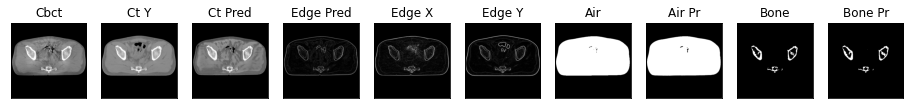

148it [00:57,  2.68it/s]

ssim score = 0.7834548354148865
psnr score = 21.379344940185547
snr score = 12.58150863647461
mae error = 0.037842411547899246
air dice score = 0.9976358249282322
bone dice score = 0.9307764265679642
contour dice score = 0.35120925307273865


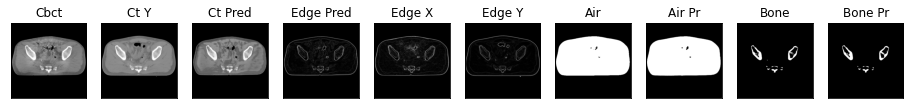

149it [00:57,  2.71it/s]

ssim score = 0.777469277381897
psnr score = 21.284133911132812
snr score = 12.499655723571777
mae error = 0.03881559148430824
air dice score = 0.9972397415534571
bone dice score = 0.9394865525681618
contour dice score = 0.3287671208381653


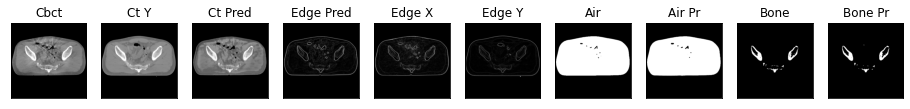

150it [00:58,  2.72it/s]

ssim score = 0.7745740413665771
psnr score = 21.177539825439453
snr score = 12.448265075683594
mae error = 0.04013519361615181
air dice score = 0.9972969833094549
bone dice score = 0.9345745378270017
contour dice score = 0.3847780227661133


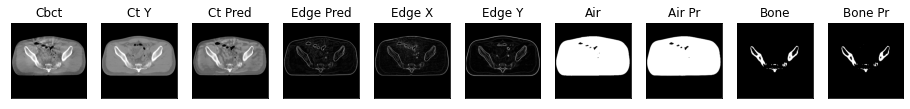

151it [00:58,  2.72it/s]

ssim score = 0.7774498462677002
psnr score = 20.83155632019043
snr score = 12.121652603149414
mae error = 0.04135791212320328
air dice score = 0.9970671756435943
bone dice score = 0.912510220769794
contour dice score = 0.4076230823993683


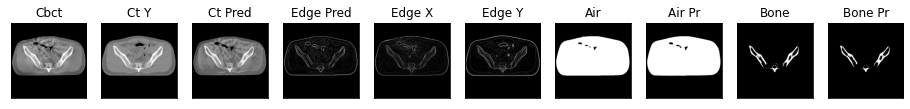

152it [00:59,  2.33it/s]

ssim score = 0.7857906818389893
psnr score = 21.089460372924805
snr score = 12.324817657470703
mae error = 0.03967200219631195
air dice score = 0.9969308035714309
bone dice score = 0.9009871373033056
contour dice score = 0.35262879729270935


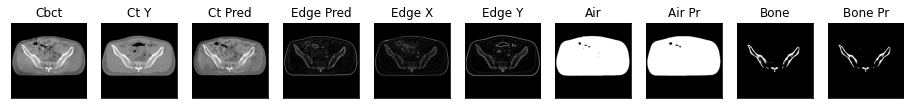

153it [00:59,  2.43it/s]

ssim score = 0.7915662527084351
psnr score = 21.350807189941406
snr score = 12.54981517791748
mae error = 0.03846200183033943
air dice score = 0.9971035145056636
bone dice score = 0.8923031026269048
contour dice score = 0.3878529667854309


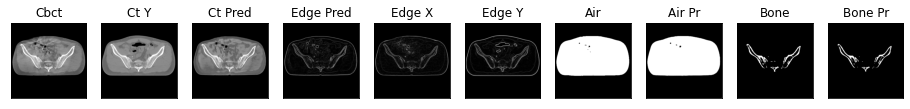

154it [00:59,  2.50it/s]

ssim score = 0.7959612011909485
psnr score = 21.512733459472656
snr score = 12.711810111999512
mae error = 0.03771616891026497
air dice score = 0.9974040465876793
bone dice score = 0.8946380697065062
contour dice score = 0.3967914581298828


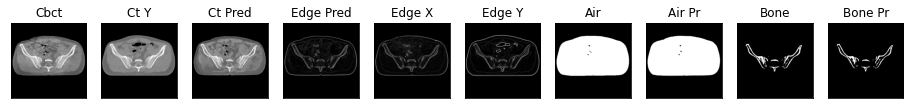

155it [01:00,  2.56it/s]

ssim score = 0.7926535606384277
psnr score = 21.614912033081055
snr score = 12.812564849853516
mae error = 0.03760857880115509
air dice score = 0.9974154591246731
bone dice score = 0.9000000000013514
contour dice score = 0.38858988881111145


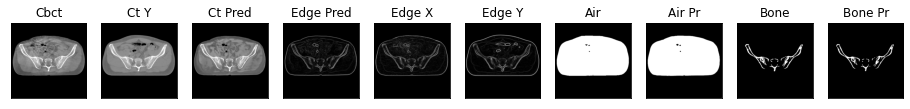

156it [01:00,  2.62it/s]

ssim score = 0.7851698398590088
psnr score = 21.181415557861328
snr score = 12.384109497070312
mae error = 0.0388050302863121
air dice score = 0.9970102306171094
bone dice score = 0.8989499522719357
contour dice score = 0.3818280100822449


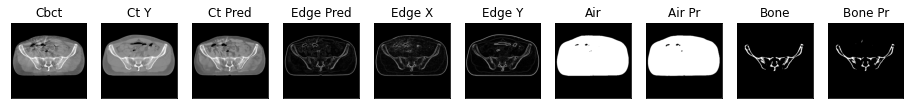

157it [01:00,  2.66it/s]

ssim score = 0.7824236750602722
psnr score = 20.763261795043945
snr score = 11.948681831359863
mae error = 0.04021512344479561
air dice score = 0.9963460530330918
bone dice score = 0.885922664099547
contour dice score = 0.33968427777290344


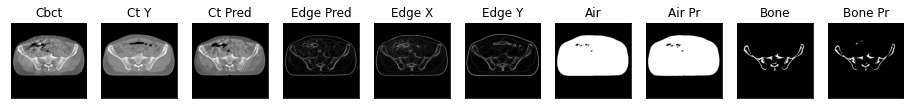

158it [01:01,  2.66it/s]

ssim score = 0.7794638872146606
psnr score = 20.647613525390625
snr score = 11.814411163330078
mae error = 0.040719639509916306
air dice score = 0.9970634883246203
bone dice score = 0.8892049127357569
contour dice score = 0.37431395053863525


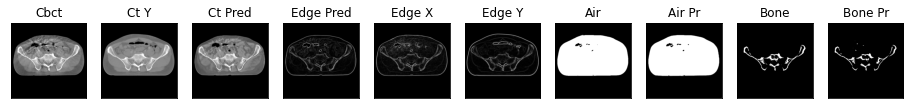

159it [01:01,  2.68it/s]

ssim score = 0.7770689129829407
psnr score = 20.441923141479492
snr score = 11.56278133392334
mae error = 0.041088003665208817
air dice score = 0.9967364570852015
bone dice score = 0.8884467106095206
contour dice score = 0.3677526116371155


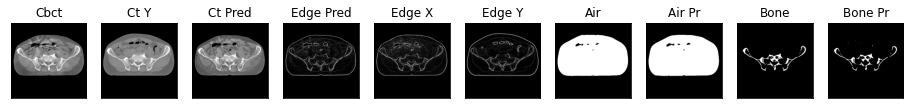

160it [01:02,  2.70it/s]

ssim score = 0.7737360596656799
psnr score = 20.482067108154297
snr score = 11.549128532409668
mae error = 0.04073856398463249
air dice score = 0.9962793495986477
bone dice score = 0.889781021899151
contour dice score = 0.37957823276519775


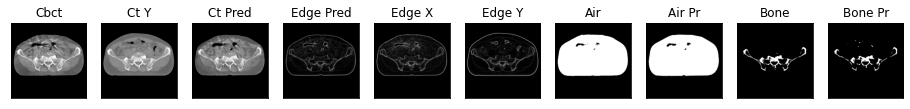

161it [01:02,  2.71it/s]

ssim score = 0.7653900980949402
psnr score = 20.12884521484375
snr score = 11.226369857788086
mae error = 0.042730867862701416
air dice score = 0.9958797327394242
bone dice score = 0.9086168069229746
contour dice score = 0.38397330045700073


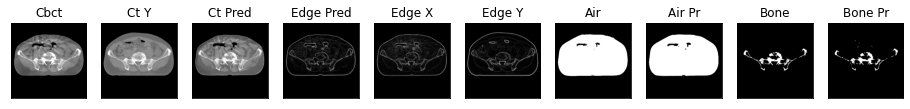

162it [01:03,  2.32it/s]

ssim score = 0.7605527639389038
psnr score = 19.984708786010742
snr score = 11.027007102966309
mae error = 0.04234491288661957
air dice score = 0.9962630375369543
bone dice score = 0.9057392159284043
contour dice score = 0.3984418511390686


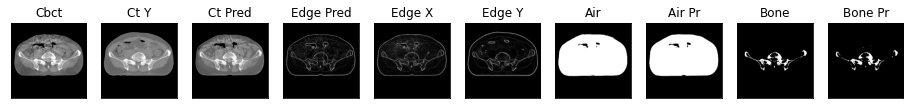

163it [01:03,  2.43it/s]

ssim score = 0.7674040198326111
psnr score = 20.616764068603516
snr score = 11.511531829833984
mae error = 0.03891976550221443
air dice score = 0.9963395669683829
bone dice score = 0.9182948490241272
contour dice score = 0.28987130522727966


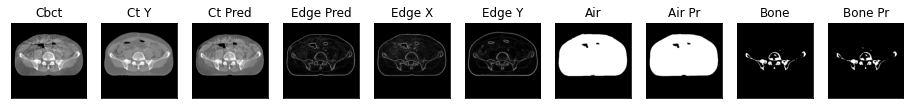

164it [01:03,  2.52it/s]

ssim score = 0.8210870623588562
psnr score = 24.642114639282227
snr score = 15.023027420043945
mae error = 0.023408381268382072
air dice score = 0.9958002730929654
bone dice score = 0.9039092055509733
contour dice score = 0.4381968080997467


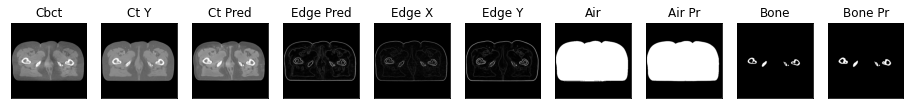

165it [01:04,  2.59it/s]

ssim score = 0.8225396871566772
psnr score = 24.819644927978516
snr score = 15.321569442749023
mae error = 0.02307618223130703
air dice score = 0.9963867695667814
bone dice score = 0.9111351351370566
contour dice score = 0.4498269855976105


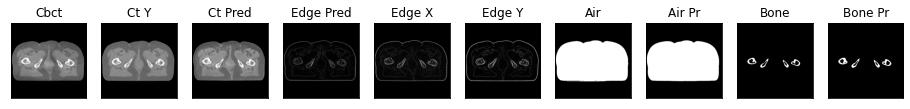

166it [01:04,  2.63it/s]

ssim score = 0.8207350969314575
psnr score = 24.751995086669922
snr score = 15.336836814880371
mae error = 0.023518195375800133
air dice score = 0.9963877357803537
bone dice score = 0.8941445737193564
contour dice score = 0.40840253233909607


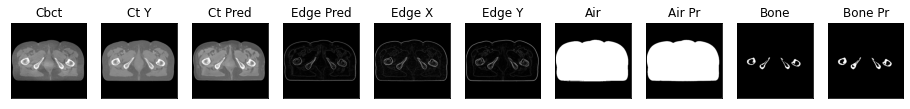

167it [01:04,  2.67it/s]

ssim score = 0.8161675333976746
psnr score = 24.667463302612305
snr score = 15.315750122070312
mae error = 0.024011867120862007
air dice score = 0.9967760865312888
bone dice score = 0.9006371620475179
contour dice score = 0.44259893894195557


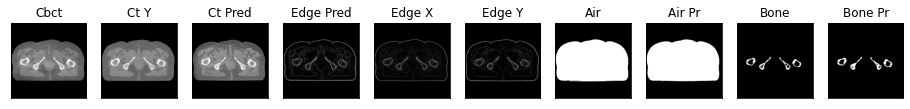

168it [01:05,  2.69it/s]

ssim score = 0.8170833587646484
psnr score = 24.58060073852539
snr score = 15.25734806060791
mae error = 0.024334004148840904
air dice score = 0.9966285726661733
bone dice score = 0.9254731200816367
contour dice score = 0.4074803292751312


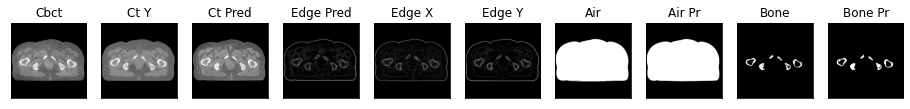

169it [01:05,  2.69it/s]

ssim score = 0.8192034959793091
psnr score = 24.511173248291016
snr score = 15.21087646484375
mae error = 0.024371907114982605
air dice score = 0.9965646628400252
bone dice score = 0.9299452973366871
contour dice score = 0.43135344982147217


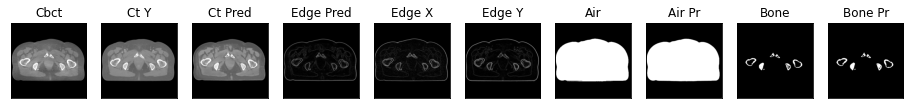

170it [01:05,  2.72it/s]

ssim score = 0.8181076645851135
psnr score = 24.42451286315918
snr score = 15.155539512634277
mae error = 0.024528710171580315
air dice score = 0.9964864379378505
bone dice score = 0.9296997049135619
contour dice score = 0.39052683115005493


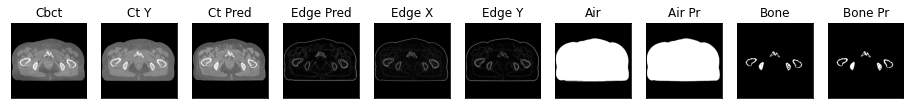

171it [01:06,  2.72it/s]

ssim score = 0.8133875131607056
psnr score = 24.207820892333984
snr score = 14.987215042114258
mae error = 0.02542111650109291
air dice score = 0.99647033503121
bone dice score = 0.9226079593577882
contour dice score = 0.42521166801452637


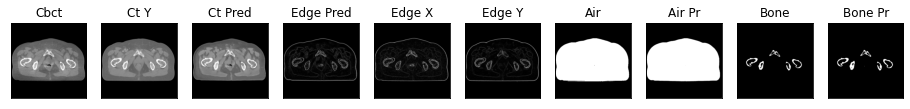

172it [01:06,  2.33it/s]

ssim score = 0.8142647743225098
psnr score = 23.946659088134766
snr score = 14.768796920776367
mae error = 0.02596333809196949
air dice score = 0.9963380483952062
bone dice score = 0.9263657957256316
contour dice score = 0.44401729106903076


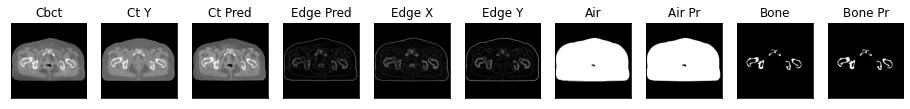

173it [01:07,  2.43it/s]

ssim score = 0.8141986727714539
psnr score = 23.816551208496094
snr score = 14.726390838623047
mae error = 0.026430396363139153
air dice score = 0.9960149636320583
bone dice score = 0.9277608635492975
contour dice score = 0.42075735330581665


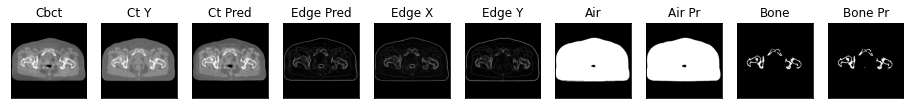

174it [01:07,  2.51it/s]

ssim score = 0.8140543103218079
psnr score = 24.356891632080078
snr score = 15.380005836486816
mae error = 0.026758527383208275
air dice score = 0.9958984765770172
bone dice score = 0.9377830750901336
contour dice score = 0.4143977761268616


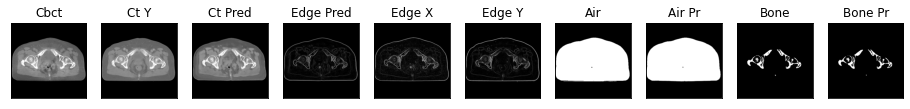

175it [01:07,  2.58it/s]

ssim score = 0.8139379024505615
psnr score = 23.869518280029297
snr score = 14.764081001281738
mae error = 0.02667207270860672
air dice score = 0.9955234677725524
bone dice score = 0.8964200477343449
contour dice score = 0.41959333419799805


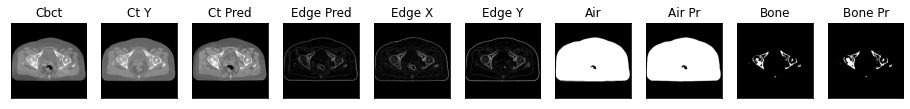

176it [01:08,  2.62it/s]

ssim score = 0.8175973296165466
psnr score = 23.919418334960938
snr score = 14.704557418823242
mae error = 0.025830719619989395
air dice score = 0.9956413761513884
bone dice score = 0.8758124011966307
contour dice score = 0.3943925201892853


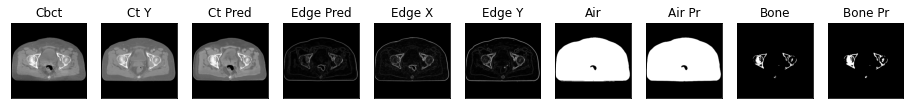

177it [01:08,  2.65it/s]

ssim score = 0.8210479021072388
psnr score = 24.0742130279541
snr score = 14.83222484588623
mae error = 0.0256047286093235
air dice score = 0.9957758940548593
bone dice score = 0.9101930132411837
contour dice score = 0.3880733847618103


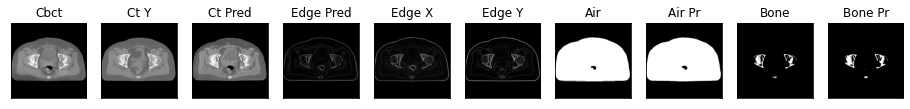

178it [01:09,  2.68it/s]

ssim score = 0.8224065899848938
psnr score = 24.602008819580078
snr score = 15.35201644897461
mae error = 0.025281812995672226
air dice score = 0.9962003551995725
bone dice score = 0.9183417085439959
contour dice score = 0.3955223858356476


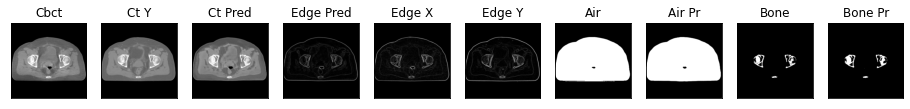

179it [01:09,  2.69it/s]

ssim score = 0.8210156559944153
psnr score = 25.107994079589844
snr score = 15.892230987548828
mae error = 0.024270808324217796
air dice score = 0.9962338782637995
bone dice score = 0.9306630253386335
contour dice score = 0.39095619320869446


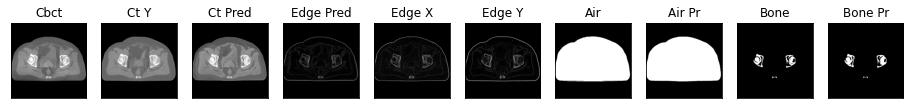

180it [01:09,  2.71it/s]

ssim score = 0.820058286190033
psnr score = 24.813785552978516
snr score = 15.649514198303223
mae error = 0.02485230378806591
air dice score = 0.9968535070865725
bone dice score = 0.9394501081257421
contour dice score = 0.376323401927948


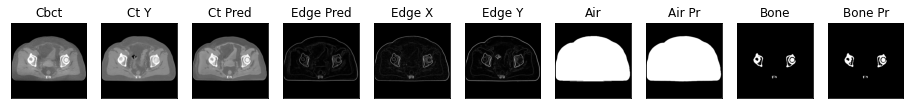

181it [01:10,  2.72it/s]

ssim score = 0.8107300400733948
psnr score = 24.16153907775879
snr score = 15.034826278686523
mae error = 0.026244306936860085
air dice score = 0.9968177268491376
bone dice score = 0.9351547070451752
contour dice score = 0.39767777919769287


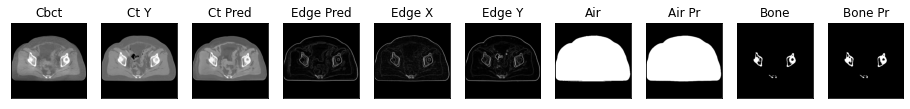

182it [01:10,  2.32it/s]

ssim score = 0.7937204837799072
psnr score = 22.59770393371582
snr score = 13.398552894592285
mae error = 0.029944803565740585
air dice score = 0.996546951862867
bone dice score = 0.8878088294878937
contour dice score = 0.38845402002334595


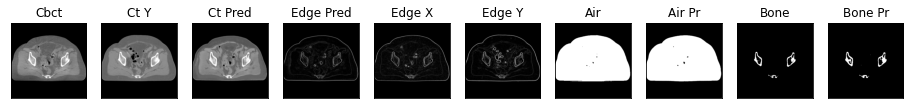

183it [01:11,  2.42it/s]

ssim score = 0.7822351455688477
psnr score = 22.25114631652832
snr score = 13.034002304077148
mae error = 0.03175032138824463
air dice score = 0.9966264337656519
bone dice score = 0.9113290214915224
contour dice score = 0.38814815878868103


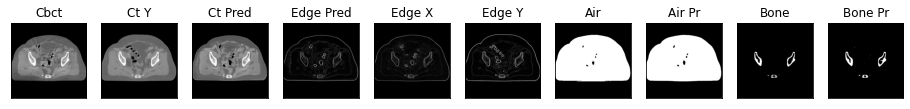

184it [01:11,  2.49it/s]

ssim score = 0.7776336073875427
psnr score = 22.809045791625977
snr score = 13.656816482543945
mae error = 0.03081876039505005
air dice score = 0.9969591337239507
bone dice score = 0.9138727163237528
contour dice score = 0.36211150884628296


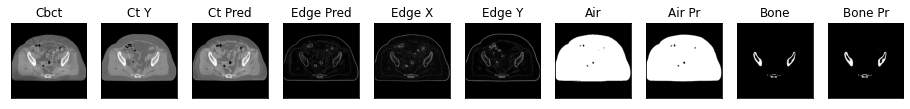

185it [01:11,  2.54it/s]

ssim score = 0.7793201208114624
psnr score = 22.996620178222656
snr score = 13.899486541748047
mae error = 0.030256258323788643
air dice score = 0.9967864563499244
bone dice score = 0.9254201680685326
contour dice score = 0.3466135561466217


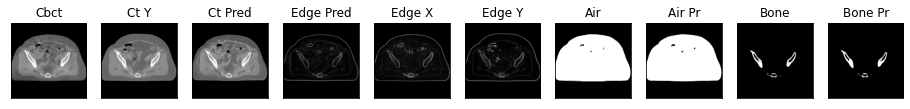

186it [01:12,  2.58it/s]

ssim score = 0.7755756974220276
psnr score = 22.416343688964844
snr score = 13.383638381958008
mae error = 0.03198742866516113
air dice score = 0.9966982286890204
bone dice score = 0.930962343097266
contour dice score = 0.3571077287197113


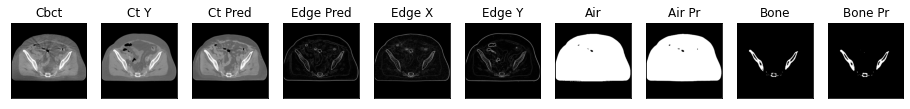

187it [01:12,  2.62it/s]

ssim score = 0.7739550471305847
psnr score = 22.237586975097656
snr score = 13.277741432189941
mae error = 0.03288554400205612
air dice score = 0.9967635415914469
bone dice score = 0.9180771834811364
contour dice score = 0.32741618156433105


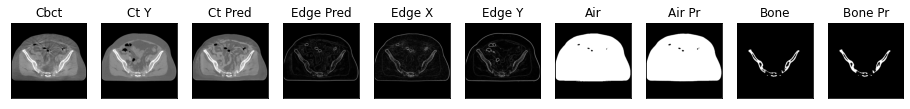

188it [01:12,  2.64it/s]

ssim score = 0.7770460844039917
psnr score = 22.22357177734375
snr score = 13.259435653686523
mae error = 0.03288594260811806
air dice score = 0.9963725879663723
bone dice score = 0.8832596166749328
contour dice score = 0.34587201476097107


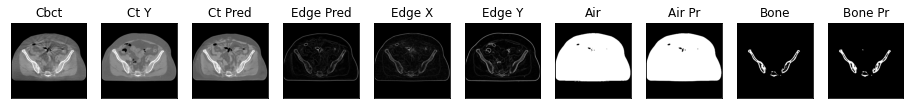

189it [01:13,  2.65it/s]

ssim score = 0.7775219678878784
psnr score = 22.30776023864746
snr score = 13.321447372436523
mae error = 0.03237703815102577
air dice score = 0.9968990748799298
bone dice score = 0.8925641359566016
contour dice score = 0.3504854440689087


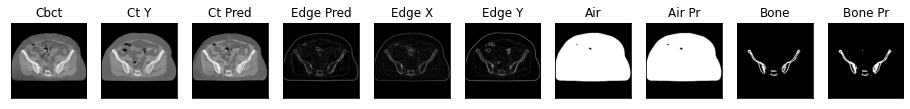

190it [01:13,  2.66it/s]

ssim score = 0.7839522957801819
psnr score = 23.0042667388916
snr score = 14.029589653015137
mae error = 0.030795684084296227
air dice score = 0.99713855036918
bone dice score = 0.8954078135723728
contour dice score = 0.37029895186424255


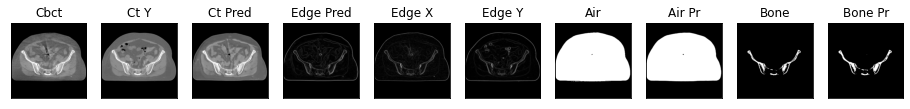

191it [01:14,  2.57it/s]


In [43]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [44]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [45]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [46]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:09, 19.16it/s]


(0.7968708554487578,
 22.505594593068068,
 13.509866614616355,
 0.03423986004675246,
 0.9971964381461703,
 0.9120715885035582,
 0.41818861639936555,
 0.5,
 0.5157068062827225)

In [47]:
# import torchvision.models as models
# models.vgg16(pretrained=True)